In [47]:
import re
import json
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [48]:
%matplotlib inline

In [49]:
def parse_metrics_from_log(filepath: Path) -> pd.DataFrame:
    """
    Parses a QUICHE log file, extracting all METRICS_LOG JSON blobs.
    
    Args:
        filepath: The Path object to the log file.

    Returns:
        A pandas DataFrame containing all metrics, or an empty DataFrame
        if no metrics are found.
    """
    # Regex to find the JSON blob in lines containing METRICS_LOG
    # It handles both "Client: METRICS_LOG {json}" and "Server: METRICS_LOG {json}"
    metrics_regex = re.compile(r'METRICS_LOG ({.*})')
    
    metrics_data = []
    
    try:
        with open(filepath, 'r') as f:
            for line in f:
                match = metrics_regex.search(line)
                if match:
                    try:
                        # Extract and parse the JSON blob
                        data = json.loads(match.group(1))
                        metrics_data.append(data)
                    except json.JSONDecodeError:
                        print(f"Warning: Skipping malformed JSON in {filepath.name}", file=sys.stderr)
                        
    except IOError as e:
        print(f"Error reading file {filepath}: {e}", file=sys.stderr)
        return pd.DataFrame()

    if not metrics_data:
        print(f"Warning: No metrics found in {filepath.name}", file=sys.stderr)
        
    return pd.DataFrame(metrics_data)

def plot_metrics(
    files: list[Path], 
    metric_key: str, 
    y_label: str, 
    title: str, 
    output_filename: str,
    scale_factor: float = 1.0,
    smoothing_window: int = 1  # New parameter for rolling average
):
    """
    Generates and saves a plot for a specific metric from a list of log files.

    Args:
        files: A list of log file Path objects to plot.
        metric_key: The key to extract from the metrics (e.g., "goodput_bps").
        y_label: The label for the Y-axis.
        title: The title for the plot.
        output_filename: The filename to save the plot as.
        scale_factor: A factor to scale the metric by (e.g., 1/1_000_000 for Mbps).
        smoothing_window: The window size for a rolling average. 1 = no smoothing.
    """
    plt.figure(figsize=(15, 7))
    label_to_name = {
        'QBIC': 'Cubic',
        'BBRR': 'BBR',
        'B2ON': 'BBRv3',
        'LLMX': 'Ours',
        'PRGC': 'Prague'
    }
    
    for filepath in files:
        # Create a clean label from the filename
        # e.g., "client_1_QBIC.txt" -> "1_QBIC"
        # e.g., "server_1.txt" -> "server_1"
        label = filepath.stem.replace("client_", "")
        
        df = parse_metrics_from_log(filepath)
        
        if not df.empty and metric_key in df.columns:
            # Ensure data is sorted by time and reset index
            df = df.sort_values(by='time_ms').reset_index()
            
            # Normalize time to start from 0 for all flows
            if 'time_ms' in df.columns:
                # df['time_sec'] = (df['time_ms'] - df['time_ms'].min()) / 1000
                df['time_sec'] = (df['time_ms']) / 1000
                
                # Apply scaling
                df['metric_scaled'] = df[metric_key] * scale_factor
                
                # Apply rolling average for smoothing if window > 1
                if smoothing_window > 1:
                    # Use min_periods=1 to get data even at the beginning
                    # center=True makes the average non-causal but more accurate
                    df['metric_smoothed'] = df['metric_scaled'].rolling(
                        window=smoothing_window, min_periods=1, center=True
                    ).mean()
                    plot_data_key = 'metric_smoothed'
                else:
                    plot_data_key = 'metric_scaled'
                
                # Plot the smoothed (or non-smoothed) data
                plt.plot(df['time_sec'].to_numpy(), df[plot_data_key].to_numpy(), label=label, alpha=0.8, lw=2)

    # constrain plots
    plt.xlim(0, 300)
    if metric_key == 'goodput_bps':
        plt.ylim(0, 4)
        plt.axhline(y=12/5, color='r', linestyle='--', linewidth=2, label='Fair BW')

    plt.title(title, fontsize=16)
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    try:
        plt.savefig(output_filename)
        print(f"Successfully generated plot: {output_filename}")
    except IOError as e:
        print(f"Error saving plot {output_filename}: {e}", file=sys.stderr)
    
    plt.show()

def calculate_jains_fairness_index(values: pd.Series) -> float:
    """
    Calculates Jain's Fairness Index for a pandas Series of values (e.g., goodputs).
    JFI = (sum(x_i))^2 / (n * sum(x_i^2))
    """
    x = values.to_numpy()
    n = len(x)
    
    if n == 0:
        return 1.0  # Trivial case: no 
        




    sum_x = np.sum(x)
    sum_x_sq = np.sum(x**2)
    
    denominator = n * sum_x_sq
    
    if denominator == 0:
        # This implies all x_i are 0, which is perfectly "fair"
        return 1.0
        
    numerator = sum_x ** 2
    jfi = numerator / denominator
    return jfi

def plot_jains_fairness(
    client_files: list[Path],
    output_filename: str,
    smoothing_window: int = 1
):
    """
    Parses all client logs, calculates JFI over time, and plots it.
    """
    all_flows = []
    
    for filepath in client_files:
        df = parse_metrics_from_log(filepath)
        if not df.empty and 'goodput_bps' in df.columns:
            df['time_sec'] = df['time_ms'] / 1000
            flow_name = filepath.stem.replace("client_", "")
            
            # Create a Series with time as index and goodput as values
            flow_series = df.set_index('time_sec')['goodput_bps'].rename(flow_name)
            all_flows.append(flow_series)

    if not all_flows:
        print("Error: No client goodput data found to calculate JFI.", file=sys.stderr)
        return

    # Combine all flows into one DataFrame.
    # This aligns them by time_sec, creating NaNs where flows don't overlap.
    combined_df = pd.concat(all_flows, axis=1)
    
    # Sort by time index
    combined_df = combined_df.sort_index()
    
    # Forward-fill NaNs (assume goodput is constant until next report)
    # Then, fill remaining NaNs (at the very beginning) with 0.0
    combined_df = combined_df.ffill().fillna(0.0)

    # Calculate JFI for each row (each timestamp)
    jfi_series = combined_df.apply(calculate_jains_fairness_index, axis=1)

    # print jfi mean and err for plotting
    print(f"Mean: {jfi_series.mean()}")
    print(f"SEM: {jfi_series.sem()}")

    # Apply smoothing to the final JFI series
    if smoothing_window > 1:
        jfi_to_plot = jfi_series.rolling(
            window=smoothing_window, min_periods=1, center=True
        ).mean()
        plot_label = f'JFI (Smoothed, window={smoothing_window})'
    else:
        jfi_to_plot = jfi_series
        plot_label = 'JFI (Raw)'

    # --- Plotting ---
    plt.figure(figsize=(15, 7))
    plt.plot(jfi_to_plot.index.to_numpy(), jfi_to_plot.values, label=plot_label, color='b', lw=2)

    plt.title("Jain's Fairness Index (JFI) over Time", fontsize=16)
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel("Jain's Fairness Index (0.0 to 1.0)", fontsize=12)
    plt.ylim(0.8, 1.1)  # JFI is bounded [0, 1]
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.xlim(0,300)

    try:
        plt.savefig(output_filename)
        print(f"Successfully generated plot: {output_filename}")
    except IOError as e:
        print(f"Error saving plot {output_filename}: {e}", file=sys.stderr)
    
    plt.show()

# --- NEW FUNCTION ---
def aggregate_data_for_boxplot(
    client_files: list[Path],
    server_files: list[Path],
    metric_key: str,
    file_type: str,
    label_map: dict,
    start_time_ms: int = 30000
) -> dict:
    """
    Aggregates data for box plots by grouping flows by algorithm.
    **Collects ALL data points** (not the mean) from the steady state of each flow.

    Args:
        client_files: List of all client log file paths.
        server_files: List of all server log file paths.
        metric_key: The metric to extract (e.g., "goodput_bps").
        file_type: "client" or "server" (which files to parse for the metric).
        label_map: Dictionary mapping algorithm keys (e.g., "QBIC") to names.
        start_time_ms: The time (in ms) to consider the "steady state" starts.
                       Data before this time is ignored.

    Returns:
        A dictionary like {'QBIC': [f1_pt1, f1_pt2, ..., f2_pt1, f2_pt2, ...]}
    """
    data_by_algo = defaultdict(list)
    algo_lookup = {}  # Maps flow ID '1' -> 'QBIC'

    # 1. Build a lookup map from flow_id to algorithm using client files
    for c_file in client_files:
        match = re.search(r'client_(\d+)_', c_file.stem)
        if not match:
            continue
        flow_id = match.group(1)
        
        found_algo = None
        for algo_key in label_map.keys():
            if f"_{algo_key}" in c_file.stem:
                found_algo = algo_key
                break
        
        if found_algo:
            algo_lookup[flow_id] = found_algo

    # 2. Determine which files to parse
    files_to_parse = client_files if file_type == 'client' else server_files
    file_prefix = 'client_' if file_type == 'client' else 'server_'

    # 3. Parse files and aggregate data
    for filepath in files_to_parse:
        match = re.search(rf'{file_prefix}(\d+)', filepath.stem)
        if not match:
            continue
            
        flow_id = match.group(1)
        algo = algo_lookup.get(flow_id)
        
        if not algo:
            print(f"Warning: Could not find algorithm for {filepath.name}", file=sys.stderr)
            continue

        df = parse_metrics_from_log(filepath)
        if df.empty or metric_key not in df.columns:
            continue

        # Get data from the "steady-state" part of the flow
        df_stable = df[df['time_ms'] > start_time_ms]
        
        if df_stable.empty:
            # Flow was too short, use all data
            if df.empty:
                continue
            all_values = df[metric_key].to_list()
        else:
            all_values = df_stable[metric_key].to_list()
            
        # *** THIS IS THE KEY CHANGE ***
        # Extend the list with all data points, rather than appending a single mean.
        data_by_algo[algo].extend(all_values)
        
    return data_by_algo

# --- NEW FUNCTION ---
def plot_summary_boxplot(
    data_by_algo: dict,
    y_label: str,
    output_filename: str,
    label_map: dict,
    scale_factor: float = 1.0
):
    """
    Generates and saves a box plot using academic-style settings.

    Args:
        data_by_algo: Aggregated data from aggregate_data_for_boxplot.
        y_label: The label for the Y-axis.
        output_filename: The filename to save the plot as.
        label_map: Dictionary to map algorithm keys to display names.
        scale_factor: A factor to scale the metric by.
    """
    
    # Academic style settings from your reference
    academic_style_settings = {
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif'],
        'font.size': 18,
        'axes.titlesize': 18,
        'axes.labelsize': 26,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 18,
        'pdf.fonttype': 42,  # Use Type 1 fonts for PDF output
        'ps.fonttype': 42    # Use Type 1 fonts for PostScript output
    }

    # Use rc_context to apply settings temporarily
    try:
        with plt.rc_context(academic_style_settings):
            fig, ax = plt.subplots(figsize=(15, 7), dpi=300)
            
            plot_data = []
            plot_labels = []

            # Sort items for consistent plot order
            sorted_items = sorted(data_by_algo.items(), key=lambda item: label_map.get(item[0], item[0]))

            for algo, values in sorted_items:
                if values:
                    # Apply scaling to the aggregated values
                    scaled_values = np.array(values) * scale_factor
                    plot_data.append(scaled_values)
                    # Use the "pretty" name from the map
                    plot_labels.append(label_map.get(algo, algo))
                    print(f"Boxplot data for {algo}: {len(scaled_values)} samples.")

            if not plot_data:
                print(f"Error: No data to plot for {output_filename}", file=sys.stderr)
                plt.close(fig)
                return

            # --- Plotting logic from your reference ---
            box_plot = ax.boxplot(plot_data, 
                                  patch_artist=True,  # Fill boxes with color
                                  labels=plot_labels,
                                  showfliers=False, 
                                  medianprops=dict(linewidth=2), 
                                  showmeans=False, 
                                  meanline=False)

            # Define grayscale/blue edge colors
            edge_shades = ["#1b4965", "#2c7da0", "#5fa8d3", "#90befe"] 

            for i, box in enumerate(box_plot['boxes']):
                shade = edge_shades[i % len(edge_shades)]
                box.set(facecolor="none", edgecolor=shade, linewidth=4)

            for i, (whiskerL, whiskerR) in enumerate(zip(box_plot['whiskers'][0::2],
                                                        box_plot['whiskers'][1::2])):
                shade = edge_shades[i % len(edge_shades)]
                whiskerL.set(color=shade, linewidth=4)
                whiskerR.set(color=shade, linewidth=4)

            for i, (capL, capR) in enumerate(zip(box_plot['caps'][0::2],
                                                box_plot['caps'][1::2])):
                shade = edge_shades[i % len(edge_shades)]
                capL.set(color=shade, linewidth=4)
                capR.set(color=shade, linewidth=4)

            for i, median in enumerate(box_plot['medians']):
                median.set(color=edge_shades[i % len(edge_shades)], linewidth=2.5)

            ax.set_xticks(np.arange(1, len(plot_labels) + 1))
            ax.set_xticklabels(plot_labels, ha='center')
            
            ax.set_ylabel(y_label)

            # Clean plot
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(axis='y', linestyle='--', alpha=0.7) # Add grid

            plt.tight_layout()
            
            try:
                plt.savefig(output_filename, dpi=300, bbox_inches='tight')
                print(f"Successfully generated plot: {output_filename}")
            except IOError as e:
                print(f"Error saving plot {output_filename}: {e}", file=sys.stderr)
            
            plt.show()

    except Exception as e:
        print(f"Error applying academic plot style (may need Times New Roman font): {e}", file=sys.stderr)
        # Fallback to default style if it fails
        plt.close() # Close potentially broken plot

def plot_summary_barplot(
    data_by_algo: dict,
    y_label: str,
    output_filename: str,
    label_map: dict,
    scale_factor: float = 1.0
):
    """
    Generates and saves a bar plot of the median values,
    using academic-style settings.

    Args:
        data_by_algo: Aggregated data (dict of {algo: [values]}).
        y_label: The label for the Y-axis.
        output_filename: The filename to save the plot as.
        label_map: Dictionary to map algorithm keys to display names.
        scale_factor: A factor to scale the metric by.
    """
    
    # Academic style settings
    academic_style_settings = {
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif'],
        'font.size': 18,
        'axes.titlesize': 18,
        'axes.labelsize': 26,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 18,
        'pdf.fonttype': 42,  # Use Type 1 fonts for PDF output
        'ps.fonttype': 42    # Use Type 1 fonts for PostScript output
    }

    # Use rc_context to apply settings temporarily
    try:
        with plt.rc_context(academic_style_settings):
            fig, ax = plt.subplots(figsize=(15, 7), dpi=300)
            
            plot_data_medians = []
            plot_labels = []

            # Sort items for consistent plot order
            sorted_items = sorted(data_by_algo.items(), key=lambda item: label_map.get(item[0], item[0]))

            for algo, values in sorted_items:
                if values:
                    # Calculate the median and apply scaling
                    scaled_median = np.median(np.array(values)) * scale_factor
                    plot_data_medians.append(scaled_median)
                    # Use the "pretty" name from the map
                    plot_labels.append(label_map.get(algo, algo))
                    print(f"Bar data for {algo}: {len(values)} samples, median={scaled_median:.2f}")
                else:
                    print(f"Warning: No data for {algo}, skipping.", file=sys.stderr)


            if not plot_data_medians:
                print(f"Error: No data to plot for {output_filename}", file=sys.stderr)
                plt.close(fig)
                return

            # --- Plotting logic REVISED for bar chart ---
            
            # Create x-axis positions
            x_positions = np.arange(len(plot_labels))
            
            # Plot the bars
            bars = ax.bar(x_positions, 
                          plot_data_medians,  # Use medians as bar heights
                          align='center',
                          width=0.7)          # Bar width

            # Define grayscale/blue edge colors
            edge_shades = ["#1b4965", "#2c7da0", "#5fa8d3", "#90befe"] 

            # Apply styling to each bar
            for i, bar in enumerate(bars):
                shade = edge_shades[i % len(edge_shades)]
                bar.set_edgecolor(shade)
                bar.set_facecolor(shade)
                bar.set_linewidth(4)  # Match old boxplot line width

            # Set x-axis ticks and labels
            ax.set_xticks(x_positions)
            ax.set_xticklabels(plot_labels, ha='center')
            
            # --- End of revised plotting logic ---

            ax.set_ylabel(y_label)

            # Clean plot
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.grid(axis='y', linestyle='--', alpha=0.7) # Add grid
            
            # set ylims
            plt.ylim(0.8, 1.3)

            plt.tight_layout()
            
            try:
                plt.savefig(output_filename, dpi=300, bbox_inches='tight')
                print(f"Successfully generated plot: {output_filename}")
            except IOError as e:
                print(f"Error saving plot {output_filename}: {e}", file=sys.stderr)
            
            plt.show()

    except Exception as e:
        print(f"Error applying academic plot style (may need Times New Roman font): {e}", file=sys.stderr)
        # Fallback to default style if it fails
        plt.close() # Close potentially broken plot

Seaborn style not available, using default.


Found 5 client logs and 5 server logs.
Successfully generated plot: client_goodput.png


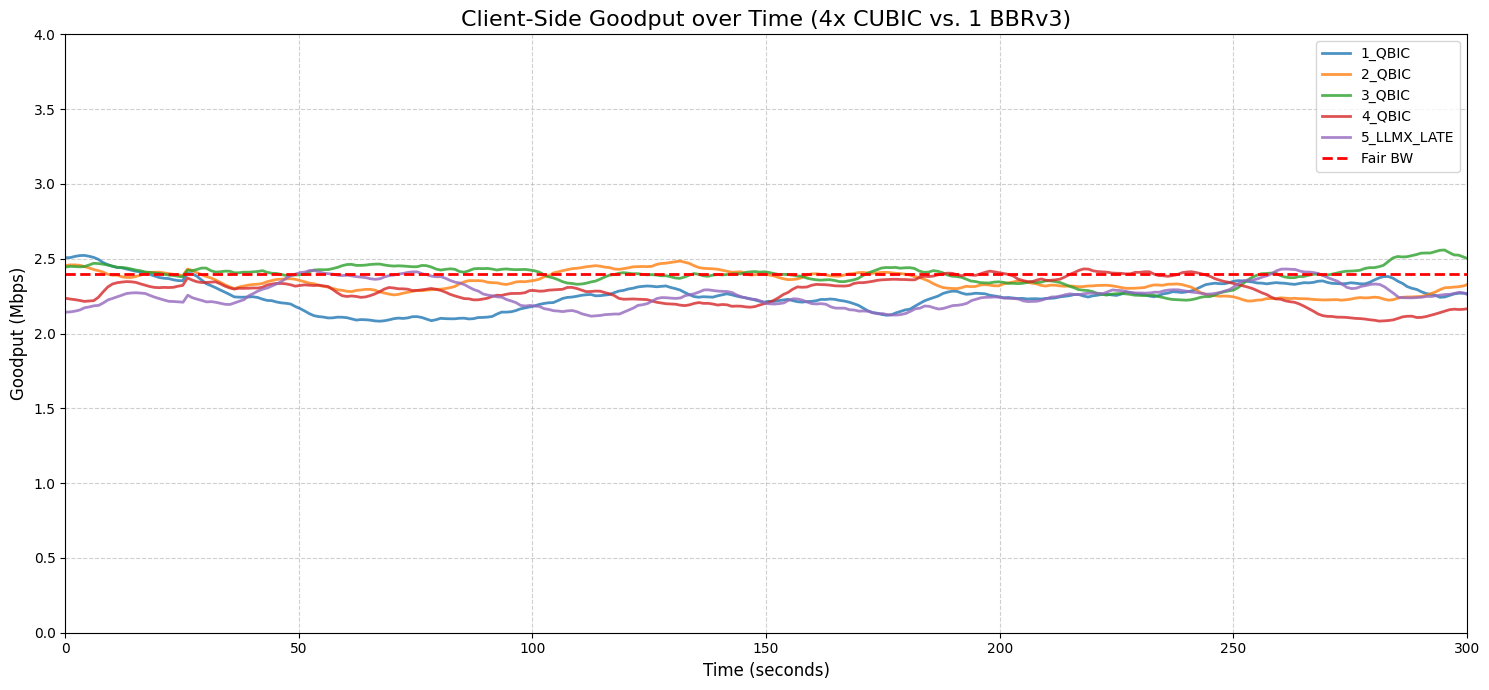

Successfully generated plot: server_cwnd.png


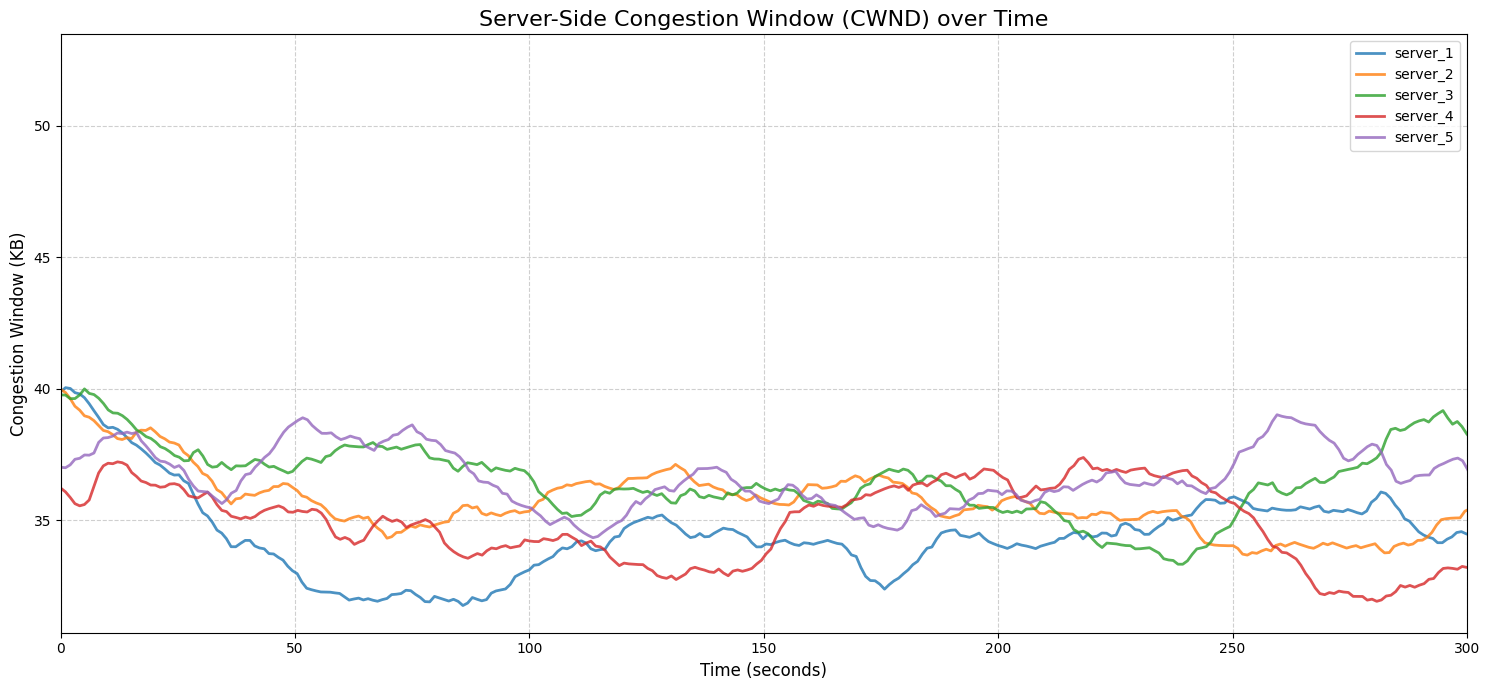

Successfully generated plot: client_srtt.png


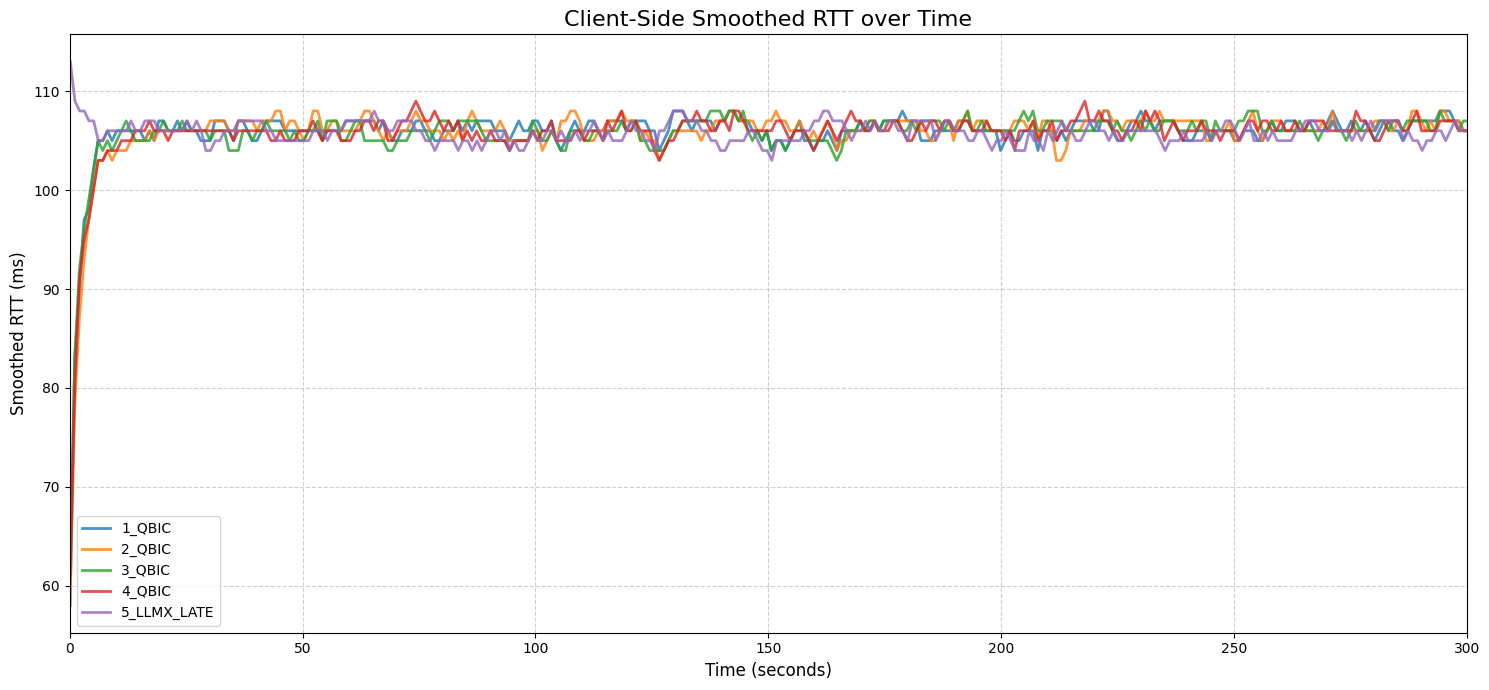

Mean: 0.9796272728761116
SEM: 0.0009831287227656073
Successfully generated plot: jains_fairness_index.png


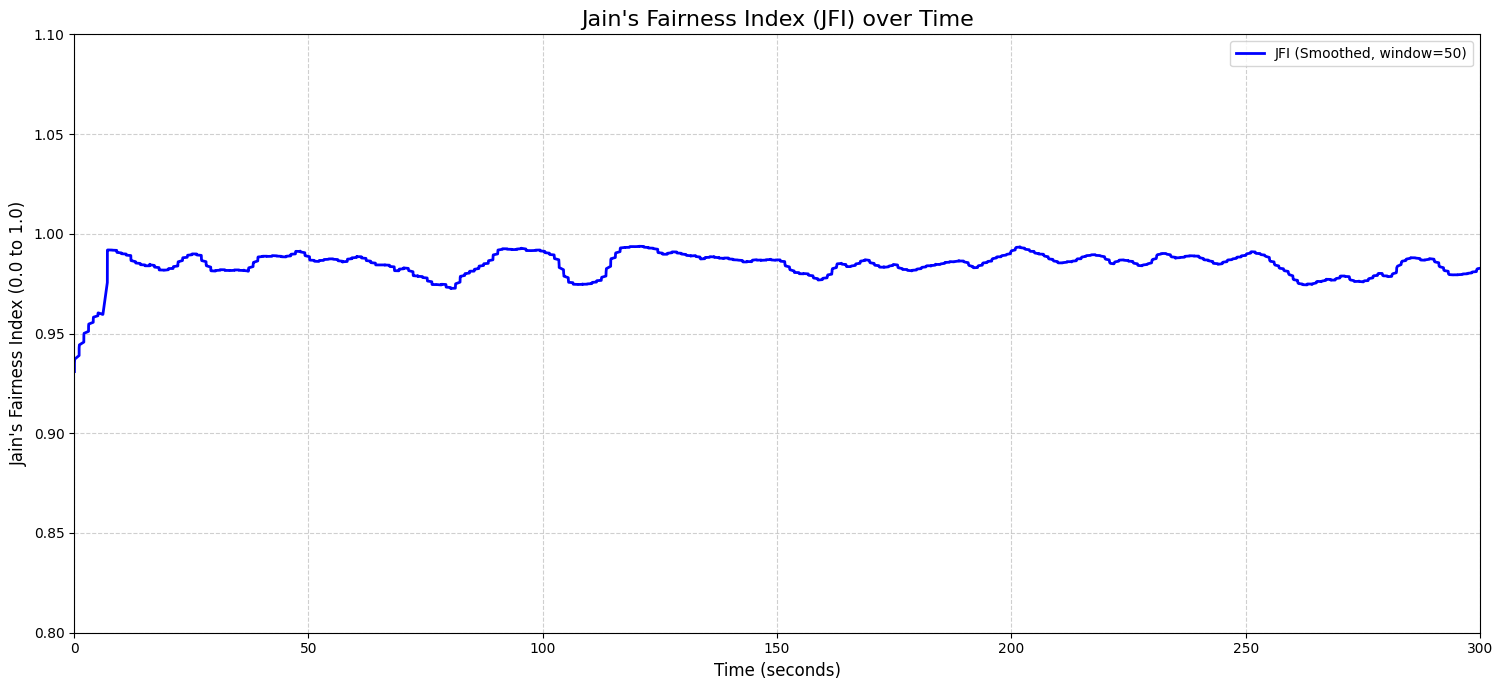

In [50]:
# Use seaborn style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except IOError:
    print("Seaborn style not available, using default.", file=sys.stderr)

log_dir = Path("./LLMX_latecomer") # Assumes script is run in the log directory
# log_dir = Path("./BBRR_latecomer") # Assumes script is run in the log directory
# log_dir = Path("./B2ON_latecomer") # Assumes script is run in the log directory

# Define pretty names for algorithms
label_to_name = {
    'QBIC': 'Cubic',
    'BBRR': 'BBR',
    'B2ON': 'BBRv3',
    'LLMX': 'Ours',
    'PRGC': 'Prague'
}

# Find all client and server log files in the current directory
client_files = sorted(log_dir.glob("client_*_*.txt"))
server_files = sorted(log_dir.glob("server_*.txt"))

if not client_files or not server_files:
    print(f"Error: No log files found in {log_dir.resolve()}", file=sys.stderr)
    print("Please run this script inside the log directory created by the experiment.", file=sys.stderr)
    print("Looking for 'client_X_*.txt' and 'server_X.txt' files.", file=sys.stderr)
    sys.exit(1)

print(f"Found {len(client_files)} client logs and {len(server_files)} server logs.")

# 1. Plot Client Goodput
plot_metrics(
    files=client_files,
    metric_key="goodput_bps",
    y_label="Goodput (Mbps)",
    title="Client-Side Goodput over Time (4x CUBIC vs. 1 BBRv3)",
    output_filename="client_goodput.png",
    scale_factor=1 / 1_000_000,  # Convert bps to Mbps
    smoothing_window=50
)

# 2. Plot Server CWND
plot_metrics(
    files=server_files,
    metric_key="cwnd_bytes",
    y_label="Congestion Window (KB)",
    title="Server-Side Congestion Window (CWND) over Time",
    output_filename="server_cwnd.png",
    scale_factor=1 / 1024,  # Convert bytes to KB
    smoothing_window=50
)

# 3. Plot Client Smoothed RTT (Bonus Plot)
plot_metrics(
    files=client_files,
    metric_key="srtt_ms",
    y_label="Smoothed RTT (ms)",
    title="Client-Side Smoothed RTT over Time",
    output_filename="client_srtt.png",
    scale_factor=1.0  # Already in ms
)

plot_jains_fairness(
    client_files=client_files,
    output_filename="jains_fairness_index.png",
    smoothing_window=50  # Use same smoothing as other plots
)


--- Generating Summary Box Plots ---
Aggregating data for Goodput box plot...
Boxplot data for QBIC: 1432 samples.
Boxplot data for LLMX: 355 samples.
Successfully generated plot: client_goodput_boxplot.png


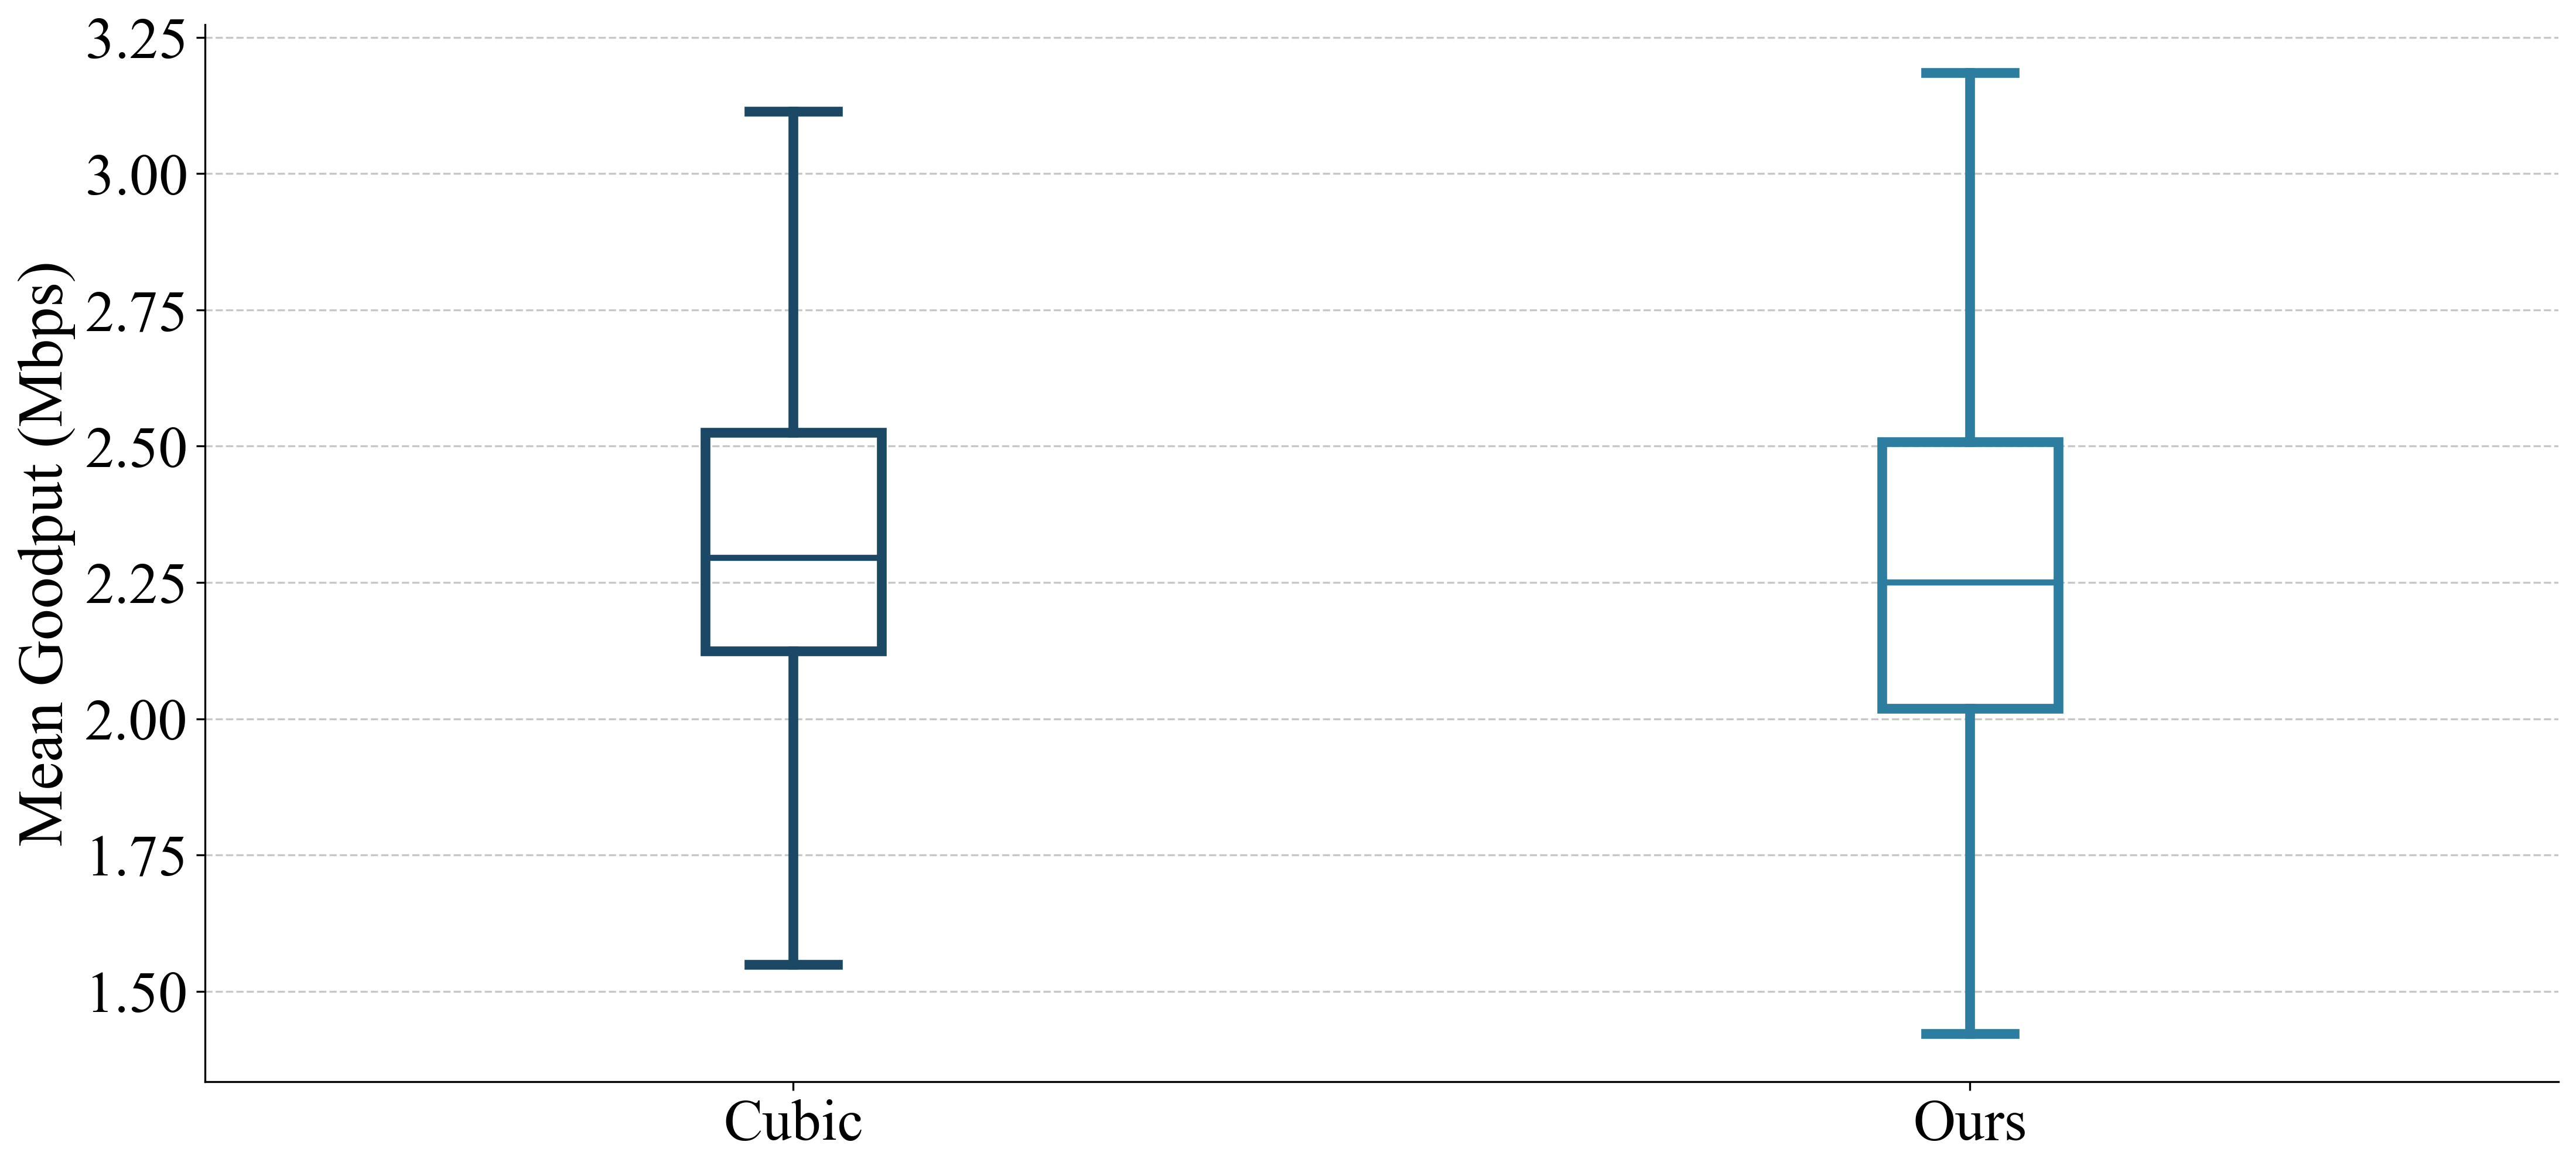

Boxplot data for QBIC: 1432 samples.
Boxplot data for LLMX: 355 samples.
Successfully generated plot: client_goodput_boxplot.png


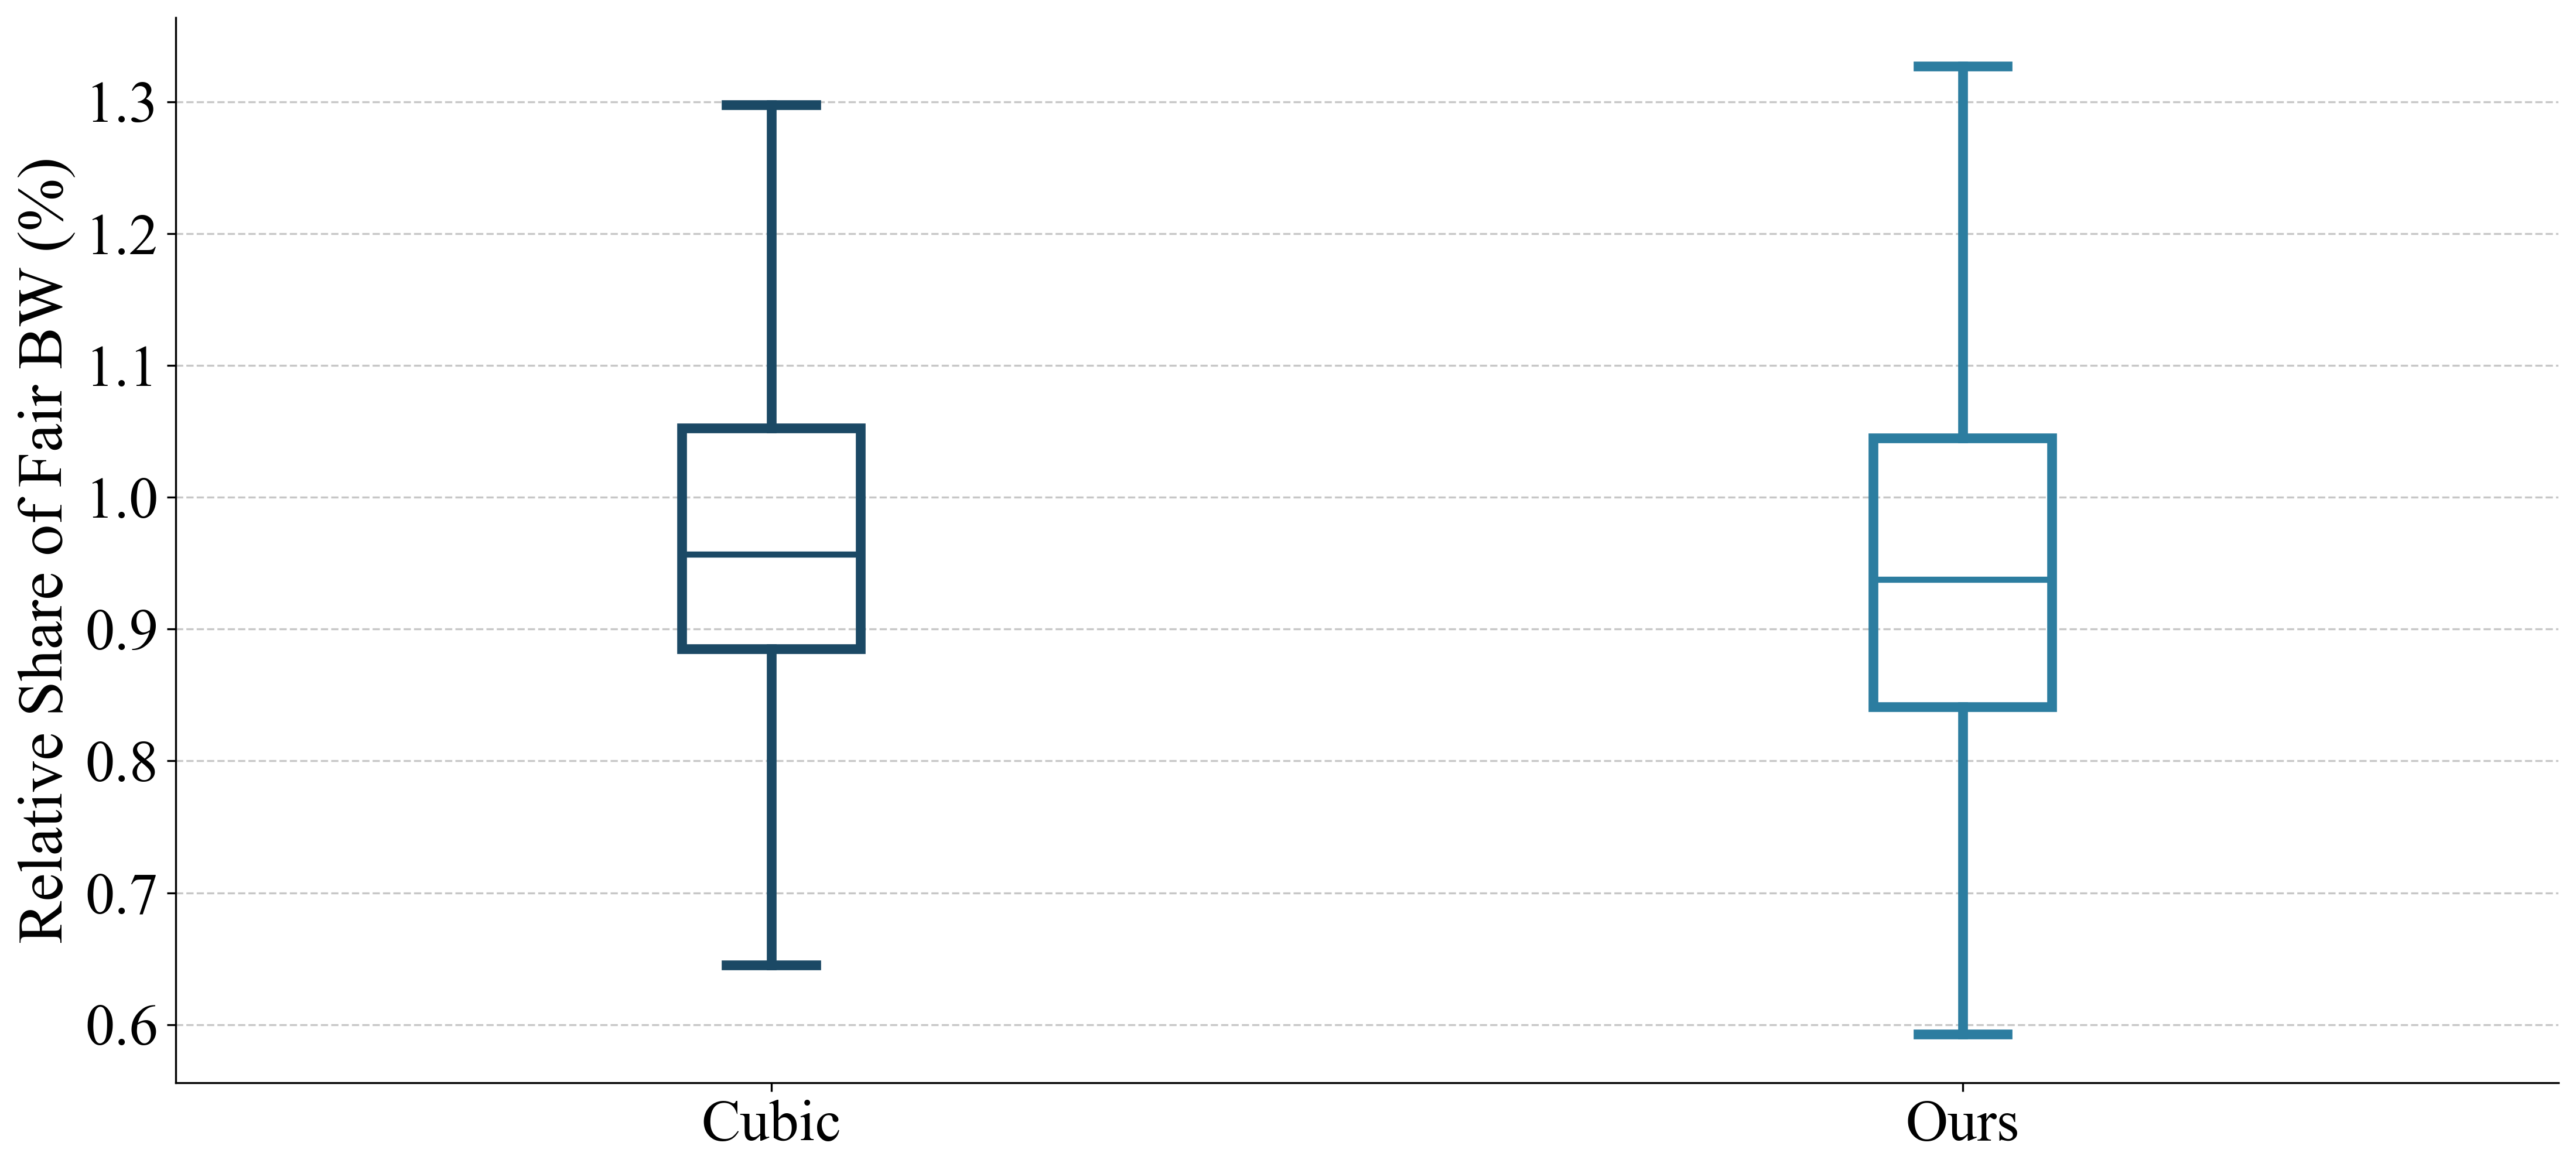

Bar data for QBIC: 1432 samples, median=0.96
Bar data for LLMX: 355 samples, median=0.94
Successfully generated plot: client_goodput_boxplot.png


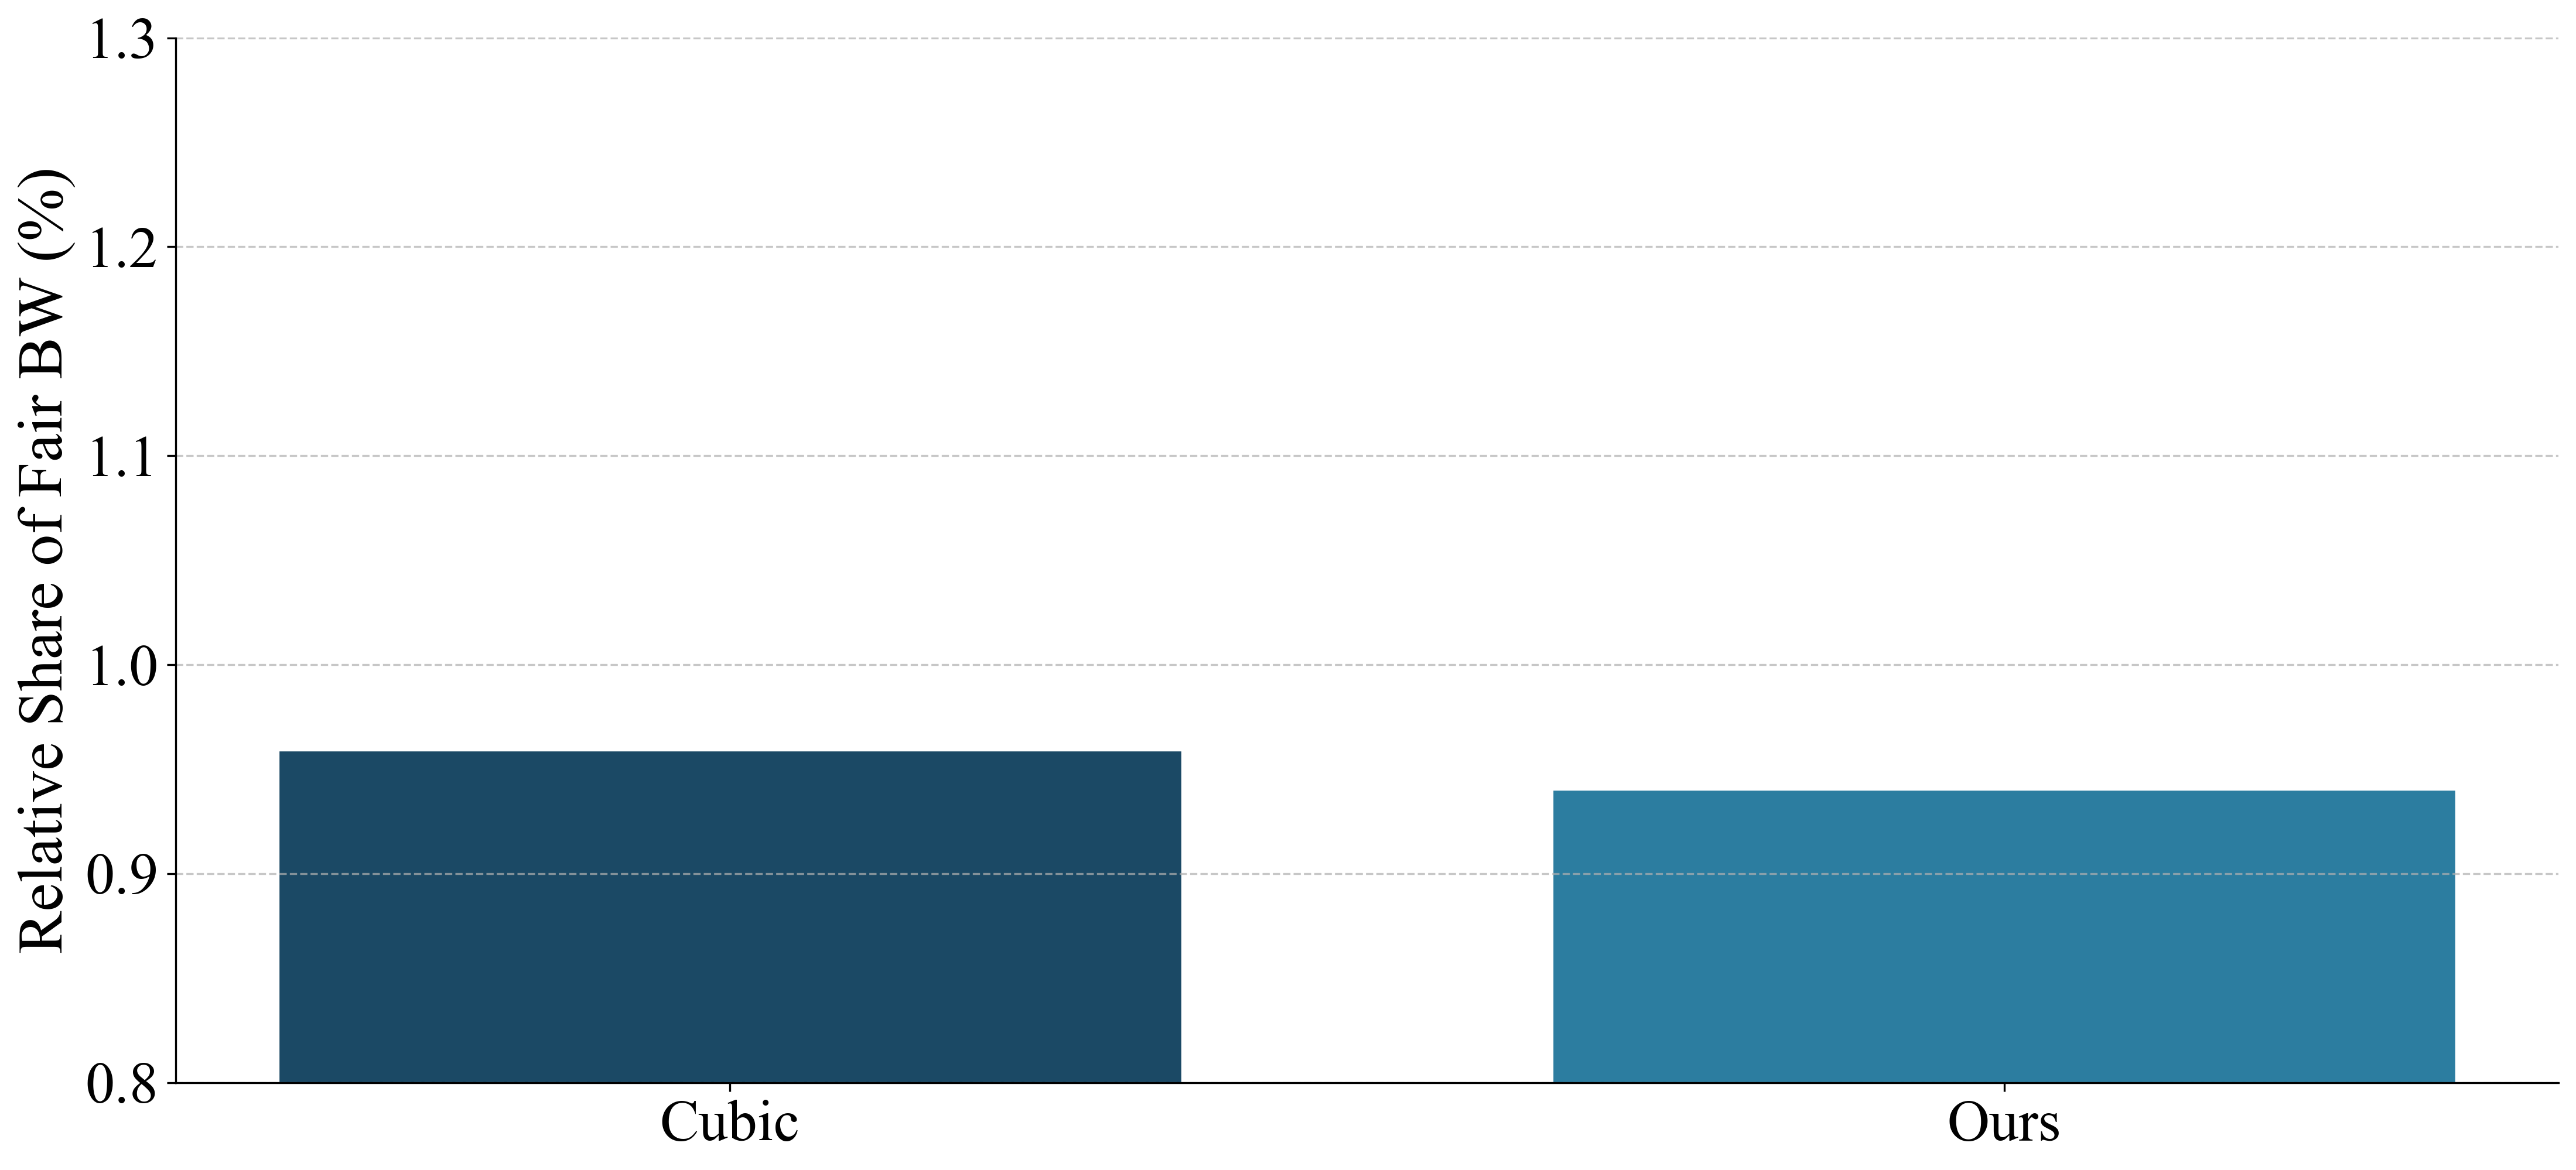

Aggregating data for CWND box plot...
Boxplot data for QBIC: 1423 samples.
Boxplot data for LLMX: 352 samples.
Successfully generated plot: server_cwnd_boxplot.png


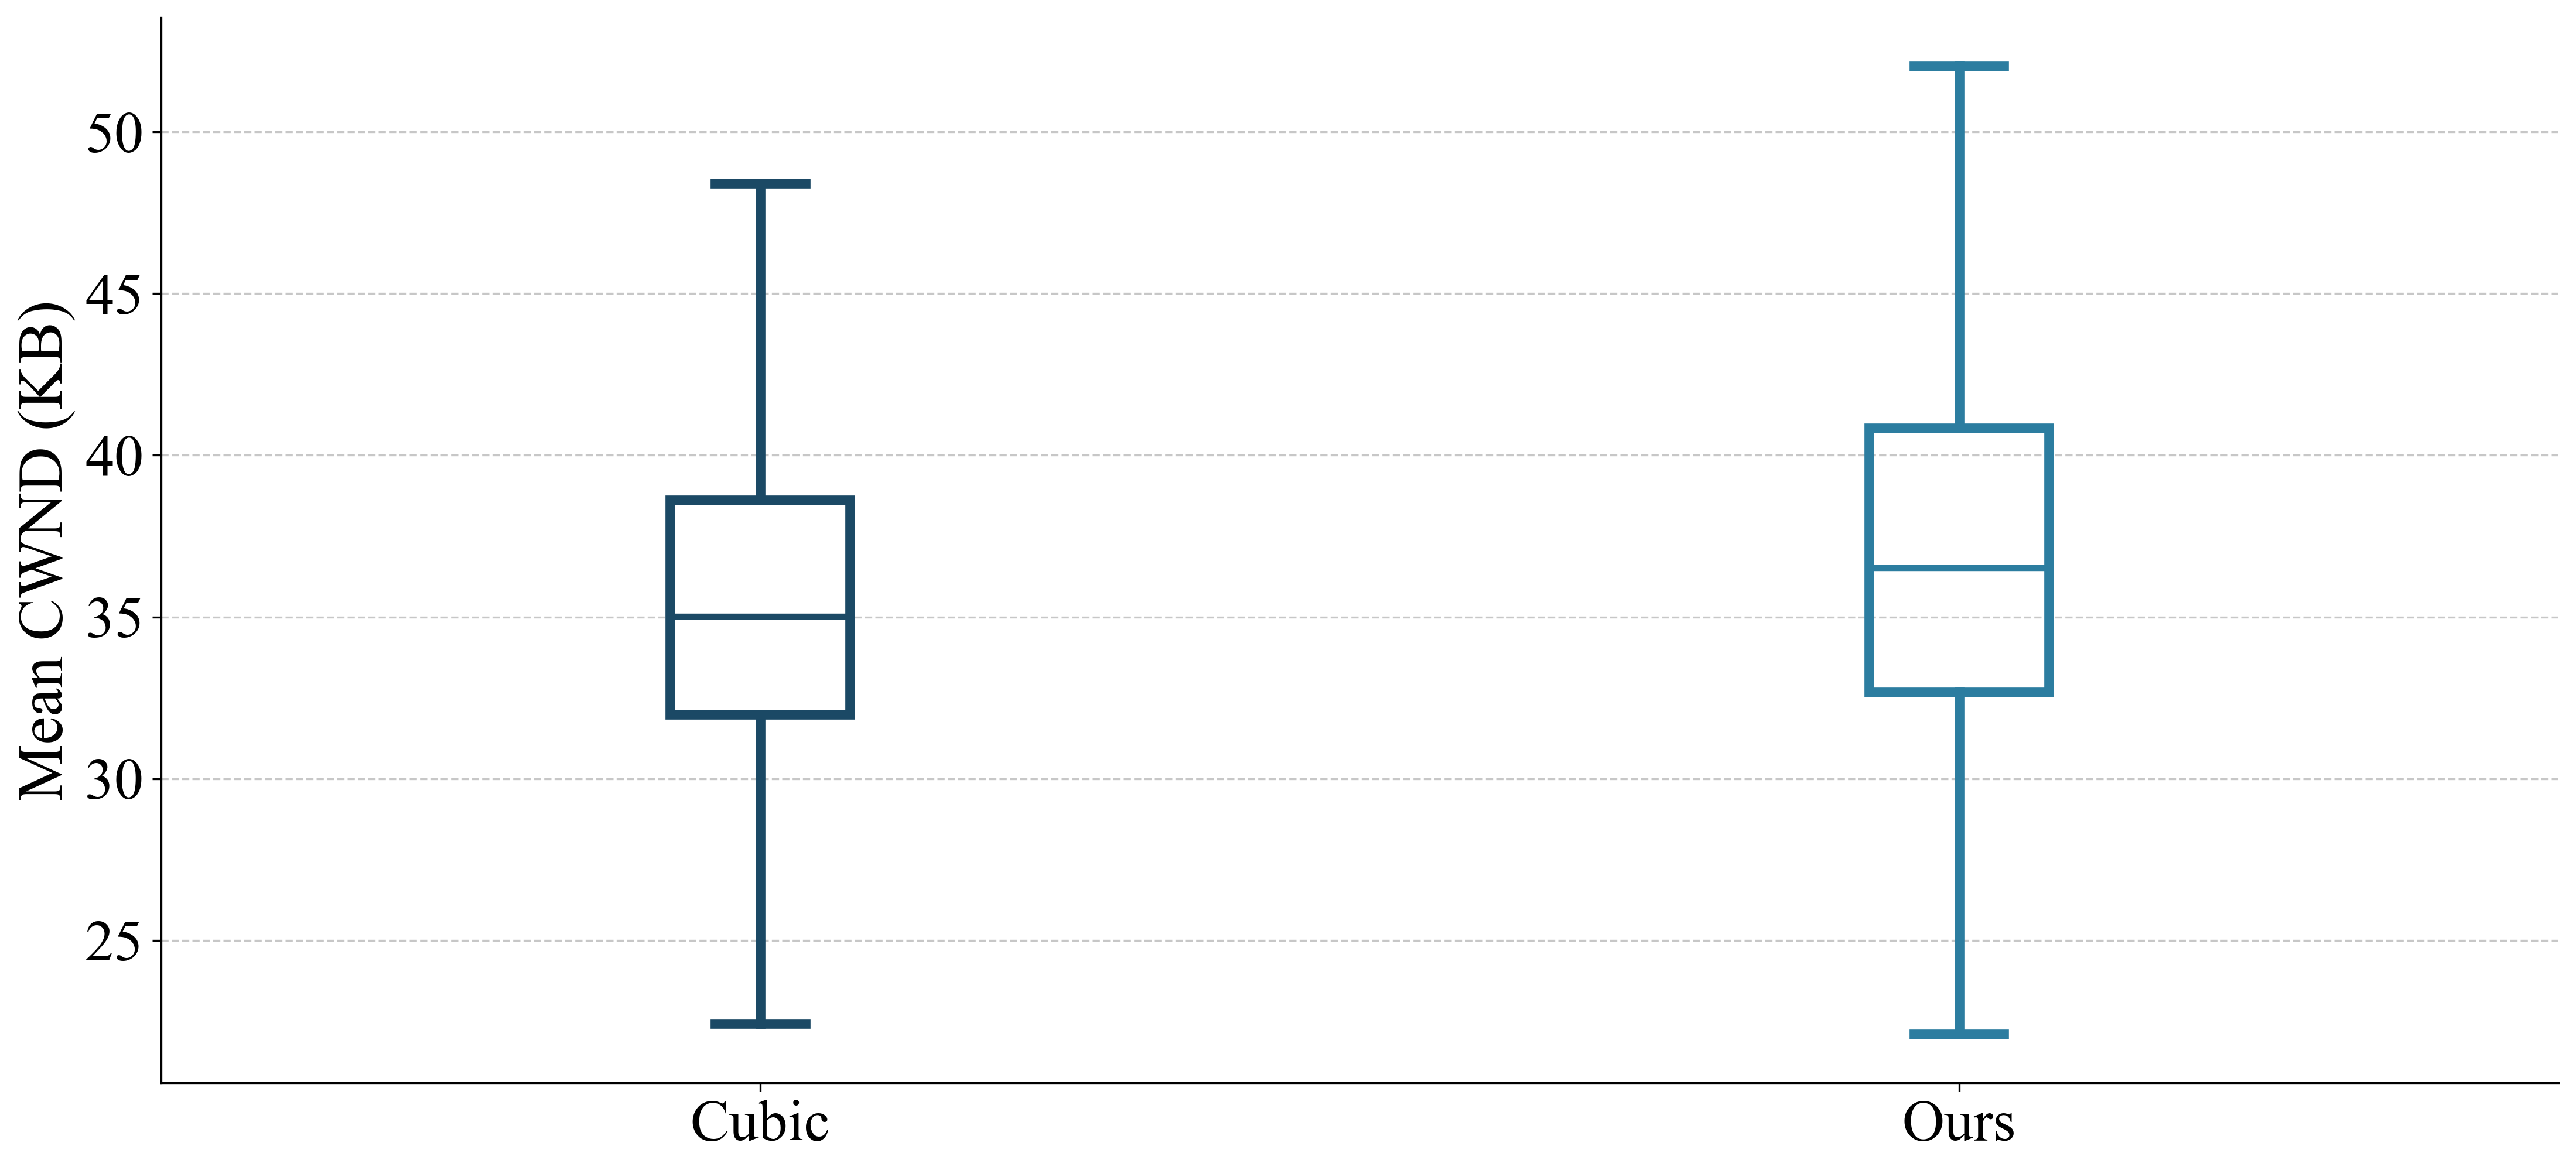

Aggregating data for SRTT box plot...
Boxplot data for QBIC: 1432 samples.
Boxplot data for LLMX: 355 samples.
Successfully generated plot: client_srtt_boxplot.png


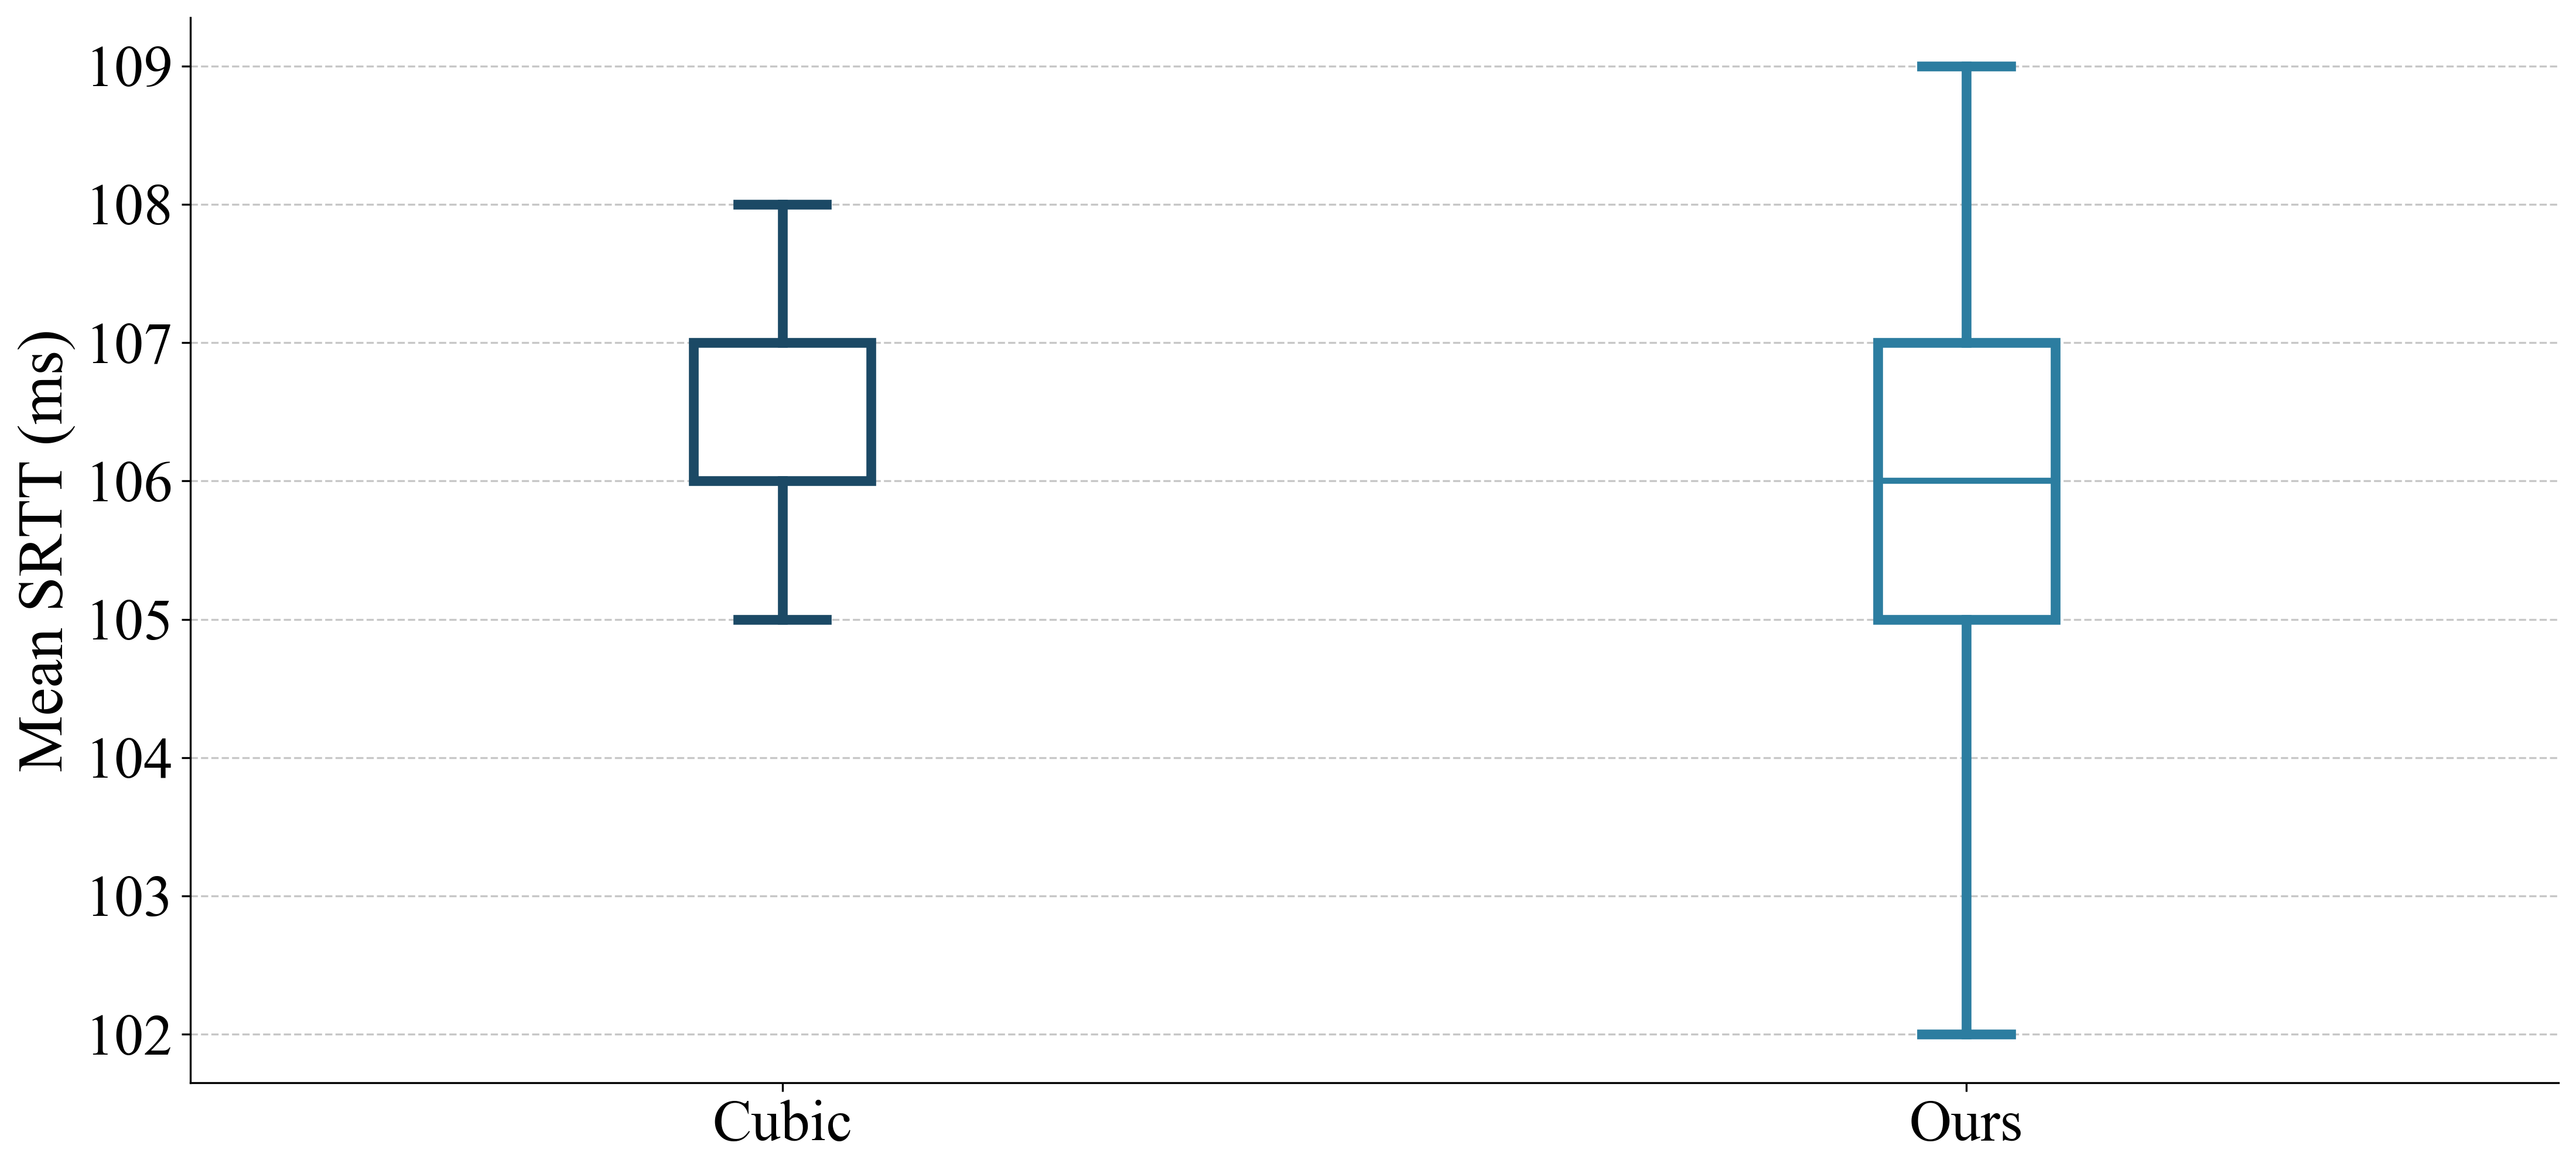

In [51]:
# --- 2. Generate Summary Box Plots ---

print("\n--- Generating Summary Box Plots ---")
# We'll calculate the mean of the metric after the first 30s
STABLE_START_TIME_MS = 0 # 30000 

# 2.1 Goodput Box Plot
print("Aggregating data for Goodput box plot...")
goodput_data = aggregate_data_for_boxplot(
    client_files=client_files,
    server_files=server_files,
    metric_key="goodput_bps",
    file_type="client",
    label_map=label_to_name,
    start_time_ms=STABLE_START_TIME_MS
)
plot_summary_boxplot(
    data_by_algo=goodput_data,
    y_label="Mean Goodput (Mbps)",
    output_filename="client_goodput_boxplot.png",
    label_map=label_to_name,
    scale_factor=1 / 1_000_000 # Convert bps to Mbps
)

throughput_data = aggregate_data_for_boxplot(
    client_files=client_files,
    server_files=server_files,
    metric_key="throughput_bps",
    file_type="client",
    label_map=label_to_name,
    start_time_ms=STABLE_START_TIME_MS
)
plot_summary_boxplot(
    data_by_algo=goodput_data,
    y_label="Relative Share of Fair BW (%)",
    output_filename="client_goodput_boxplot.png",
    label_map=label_to_name,
    scale_factor=1 / 1_000_000 / (12.0 / 5.0) # Convert bps to Mbps and to share of fair bandwidth allo
)
plot_summary_barplot(
    data_by_algo=goodput_data,
    y_label="Relative Share of Fair BW (%)",
    output_filename="client_goodput_boxplot.png",
    label_map=label_to_name,
    scale_factor=1 / 1_000_000 / (12.0 / 5.0) # Convert bps to Mbps and to share of fair bandwidth allo
)

# 2.2 CWND Box Plot
print("Aggregating data for CWND box plot...")
cwnd_data = aggregate_data_for_boxplot(
    client_files=client_files,
    server_files=server_files,
    metric_key="cwnd_bytes",
    file_type="server",
    label_map=label_to_name,
    start_time_ms=STABLE_START_TIME_MS
)
plot_summary_boxplot(
    data_by_algo=cwnd_data,
    y_label="Mean CWND (KB)",
    output_filename="server_cwnd_boxplot.png",
    label_map=label_to_name,
    scale_factor=1 / 1024 # Convert bytes to KB
)

# 2.3 SRTT Box Plot
print("Aggregating data for SRTT box plot...")
srtt_data = aggregate_data_for_boxplot(
    client_files=client_files,
    server_files=server_files,
    metric_key="srtt_ms",
    file_type="client",
    label_map=label_to_name,
    start_time_ms=STABLE_START_TIME_MS
)
plot_summary_boxplot(
    data_by_algo=srtt_data,
    y_label="Mean SRTT (ms)",
    output_filename="client_srtt_boxplot.png",
    label_map=label_to_name,
    scale_factor=1.0 # Already in ms
)

### Jain's Fairness Index
- BBRv3: Mean: 0.964721163223593, SEM: 0.000734833303769419
- BBR Mean: 0.9753582747308568, SEM: 0.0013641001432179954
- LLM-BBR Mean: 0.9796272728761116, SEM: 0.0009831287227656073

In [52]:
def plot_bar_chart(summary_data, label_map, ylabel, ylim=[0, 1], output='GIVE_NAME.PNG'):
    # Academic style settings from your previous code
    academic_style_settings = {
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'DejaVu Serif'],
        'font.size': 18,
        'axes.titlesize': 18,
        'axes.labelsize': 26,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 18,
        'pdf.fonttype': 42,  # Use Type 1 fonts for PDF output
        'ps.fonttype': 42    # Use Type 1 fonts for PostScript output
    }

    # Use rc_context to apply settings temporarily
    try:
        with plt.rc_context(academic_style_settings):
            fig, ax = plt.subplots(figsize=(10, 7), dpi=300) # Adjusted size slightly
            
            # --- Data Preparation ---
            # Sort items for consistent plot order based on the label_map value
            sorted_items = summary_data.items()

            plot_labels = [label_map.get(algo, algo) for algo, data in sorted_items]
            plot_means = [data['mean'] for algo, data in sorted_items]
            plot_sems = [data['sem'] for algo, data in sorted_items]

            if not plot_means:
                print(f"Error: No data to plot.", file=sys.stderr)
                plt.close(fig)
            else:
                # --- Plotting logic for bar chart with error bars ---
                
                # Create x-axis positions
                x_positions = np.arange(len(plot_labels))
                
                # Plot the bars
                bars = ax.bar(x_positions, 
                            plot_means,         # Use means as bar heights
                            align='center',
                            facecolor='none',   # No fill
                            width=0.7)          # Bar width

                # Define grayscale/blue edge colors
                edge_shades = ["#1b4965", "#2c7da0", "#5fa8d3", "#90befe"] 

                # Apply styling to each bar and add its corresponding error bar
                for i, bar in enumerate(bars):
                    shade = edge_shades[i % len(edge_shades)]
                    bar.set_edgecolor(shade)
                    bar.set_facecolor(shade)
                    bar.set_linewidth(4)
                    
                    # Add error bar for this specific bar, using the same color
                    ax.errorbar(
                        x_positions[i], 
                        plot_means[i], 
                        yerr=plot_sems[i], 
                        fmt='none',       # No marker
                        ecolor=shade,     # Match bar color
                        capsize=7,        # Width of the error bar caps
                        elinewidth=3,     # Line width of the error bar
                        markeredgewidth=3
                    )

                # Set x-axis ticks and labels
                ax.set_xticks(x_positions)
                ax.set_xticklabels(plot_labels, ha='center')
                
                # Set Y-axis label (using a generic one as none was provided)
                ax.set_ylabel(ylabel)

                # Clean plot
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                # ax.grid(axis='y', linestyle='--', alpha=0.7) # Add grid
                
                # Set Y-axis limit to start from 0, or slightly below min value
                min_val = min(plot_means) - max(plot_sems) if plot_sems else min(plot_means)
                max_val = max(plot_means) + max(plot_sems) if plot_sems else max(plot_means)
                
                # Ensure y-axis starts at 0 if all values are positive
                y_min = 0 if min_val >= 0 else min_val * 1.1
                y_max = max_val * 1.1
                
                # But if SEM is 0, let's give it some padding
                if min_val == max_val:
                    y_min = 0
                    y_max = max_val * 1.25
                    
                # And handle the case where all values are 0
                if y_min == 0 and y_max == 0:
                    y_max = 1.0
                    
                # ax.set_ylim([y_min, y_max])
                # ax.set_ylim([0.6, 1.2])
                ax.set_ylim(ylim)

                plt.tight_layout()
                
                output_filename = output
                try:
                    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
                    print(f"Successfully generated plot: {output_filename}")
                except IOError as e:
                    print(f"Error saving plot {output_filename}: {e}", file=sys.stderr)
                
                plt.show()
                plt.close(fig) # Close the figure to free memory

    except Exception as e:
        print(f"Error applying academic plot style (may need Times New Roman font): {e}", file=sys.stderr)
        # Fallback to default style if it fails
        plt.close()

Generating Jain's Fairness Index plot from summary stats...
Successfully generated plot: jain_fairness_summary_barchart.png


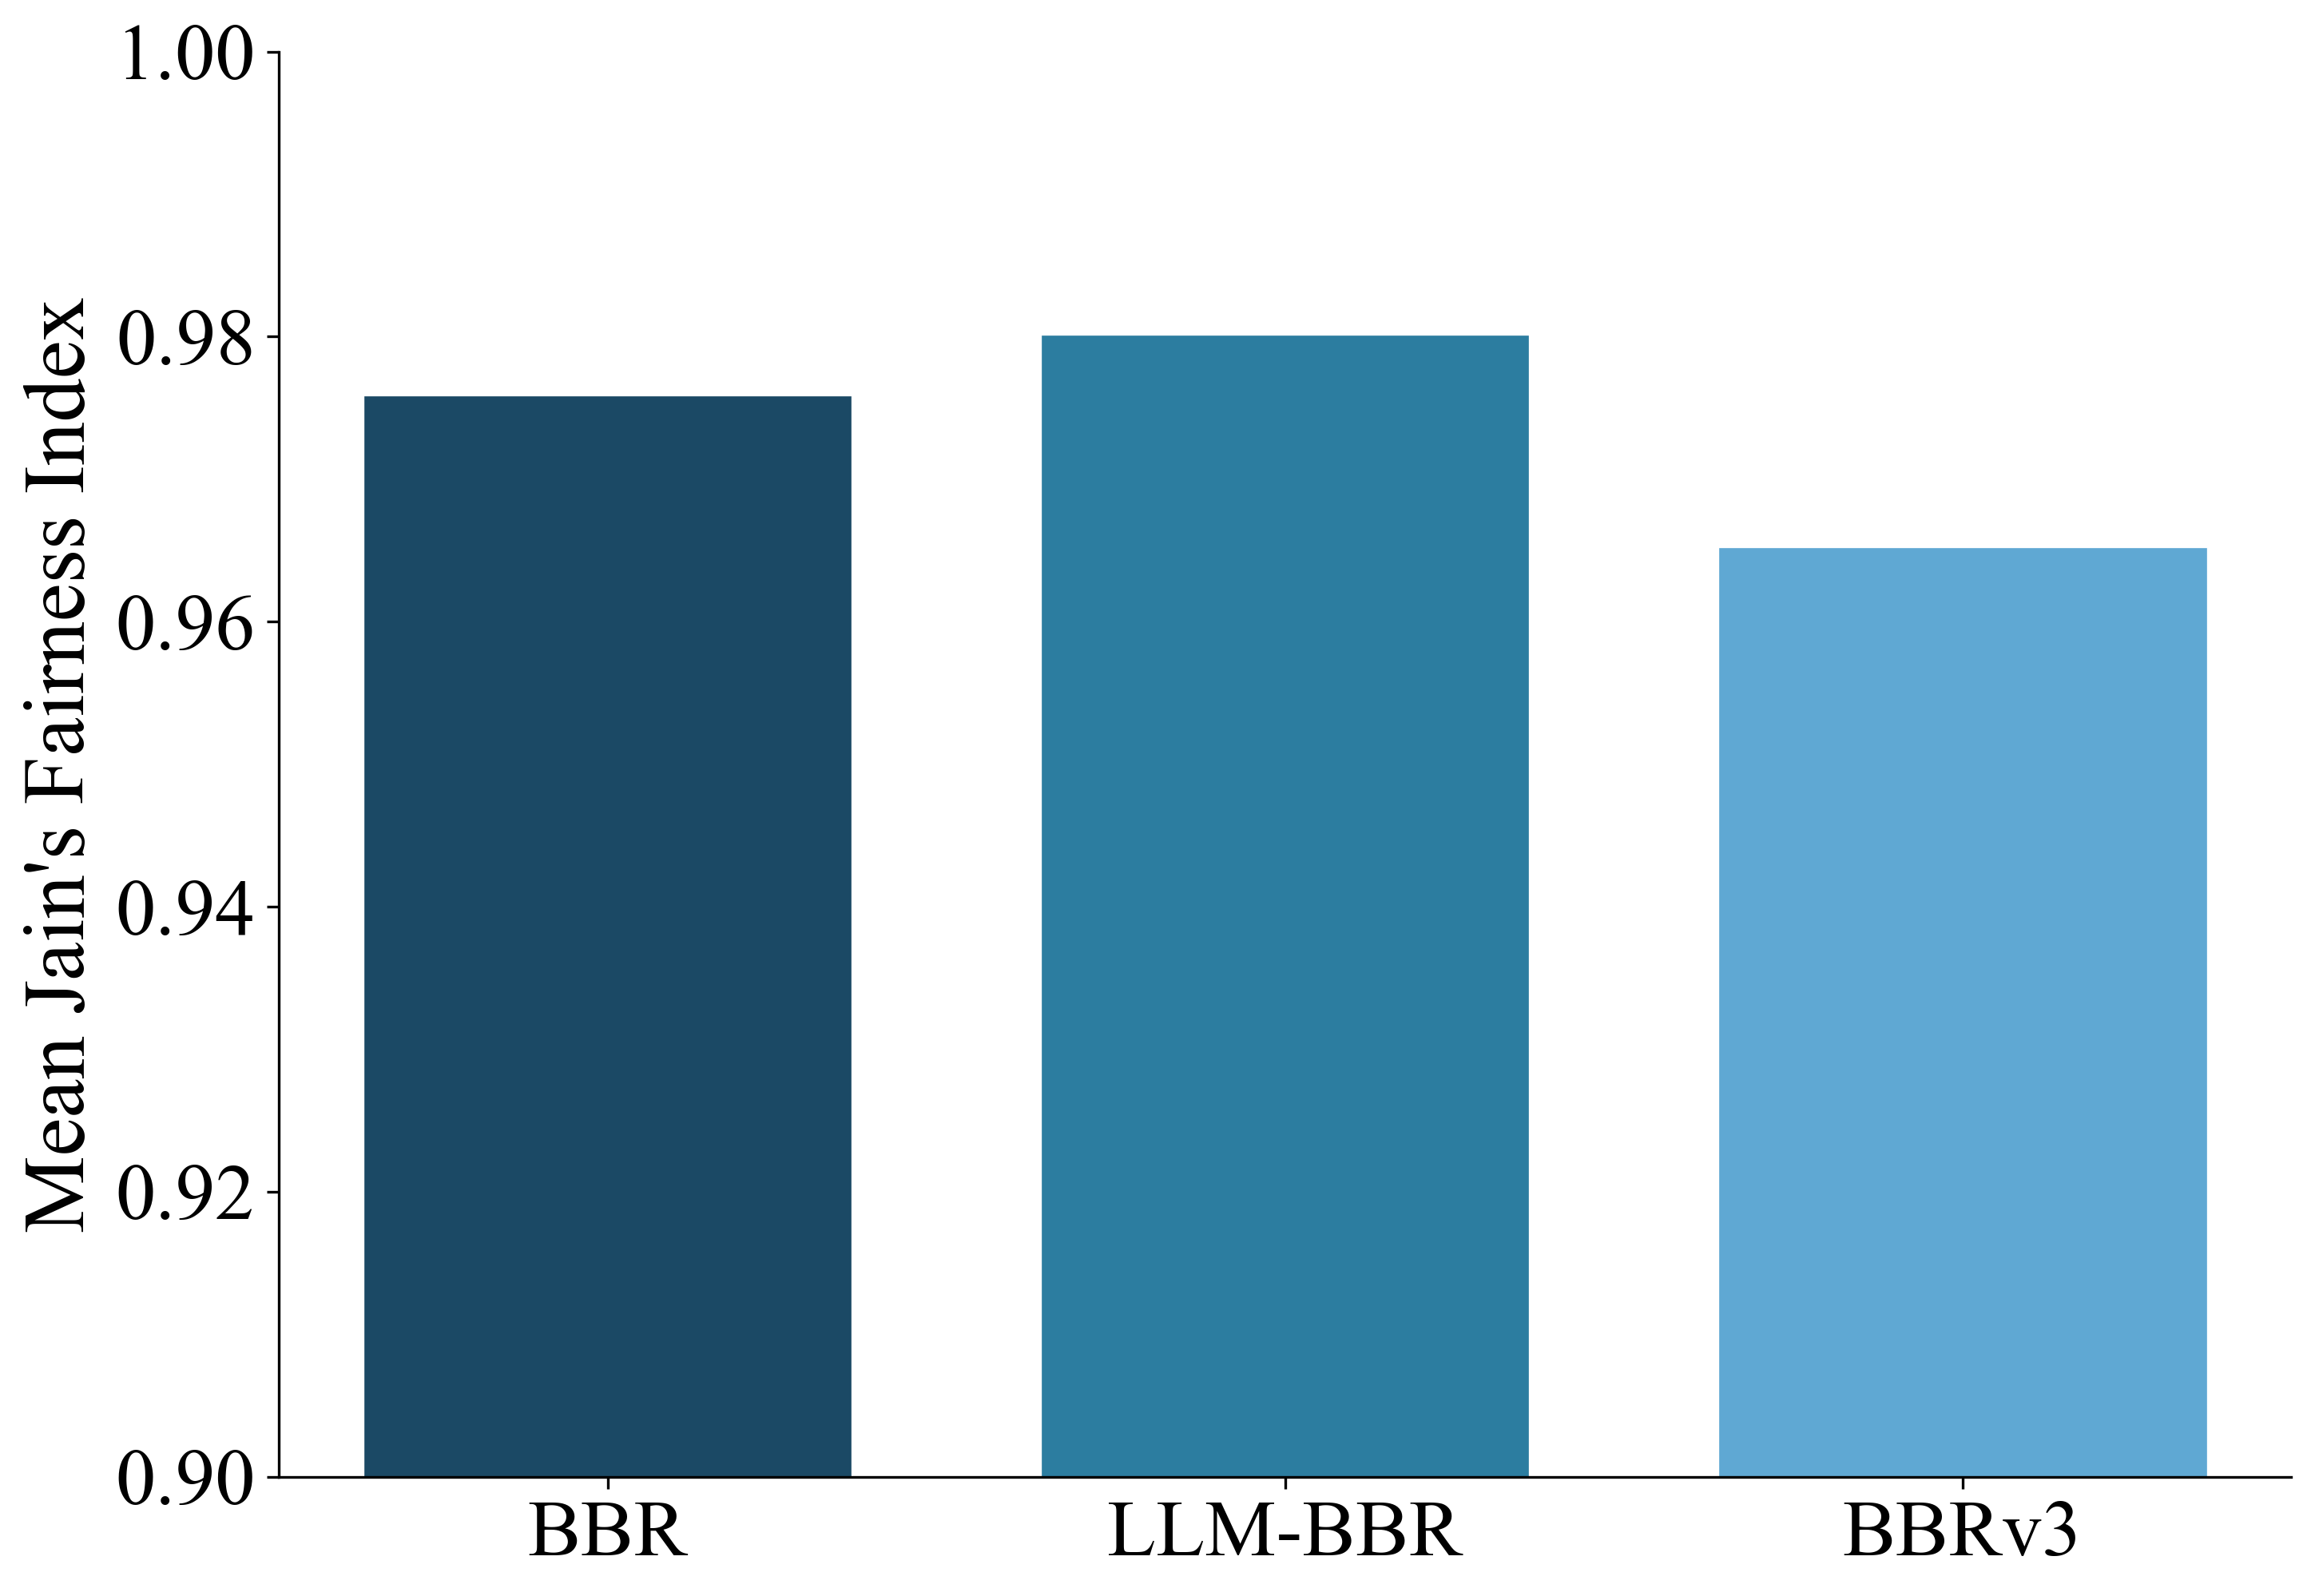

In [53]:
def plot_jain_fairness_summary():
    """
    Generates a box plot for Jain's Fairness Index from summary statistics.
    
    This function synthesizes data from the provided Mean and SEM
    to generate a distribution, as box plots cannot be drawn from
    summary statistics alone. We assume a normal distribution and
    treat the SEM as the standard deviation for the generator.
    """
    print("Generating Jain's Fairness Index plot from summary stats...")
    
    # Your provided summary data
    # summary_data = {
    #     'bbr_v3': {'mean': 0.964721163223593, 'sem': 0.000734833303769419},
    #     'bbr': {'mean': 0.9753582747308568, 'sem': 0.0013641001432179954},
    #     'llm_bbr': {'mean': 0.9796272728761116, 'sem': 0.0009831287227656073}
    # }
    summary_data = {
        'bbr': {'mean': 0.9753582747308568, 'sem': 0.0},
        'llm_bbr': {'mean': 0.9796272728761116, 'sem': 0.0},
        'bbr_v3': {'mean': 0.964721163223593, 'sem': 0.0},
    }
    
    # Map for algorithm keys to display names
    label_map = {
        'bbr': 'BBR',
        'llm_bbr': 'LLM-BBR',
        'bbr_v3': 'BBRv3'
    }

    plot_bar_chart(summary_data, label_map, "Mean Jain's Fairness Index", ylim=[0.9, 1.0], output="jain_fairness_summary_barchart.png")

plot_jain_fairness_summary()

### Median Share of Bandwidth (%)
- BBRv3: Median: 1.20
- BBR Median: 0.93
- LLM-BBR Median: 0.94
- Cubic Median: 0.96

Generating Share of Bandwidth plot from summary stats...
Successfully generated plot: share_of_bandwidth.png


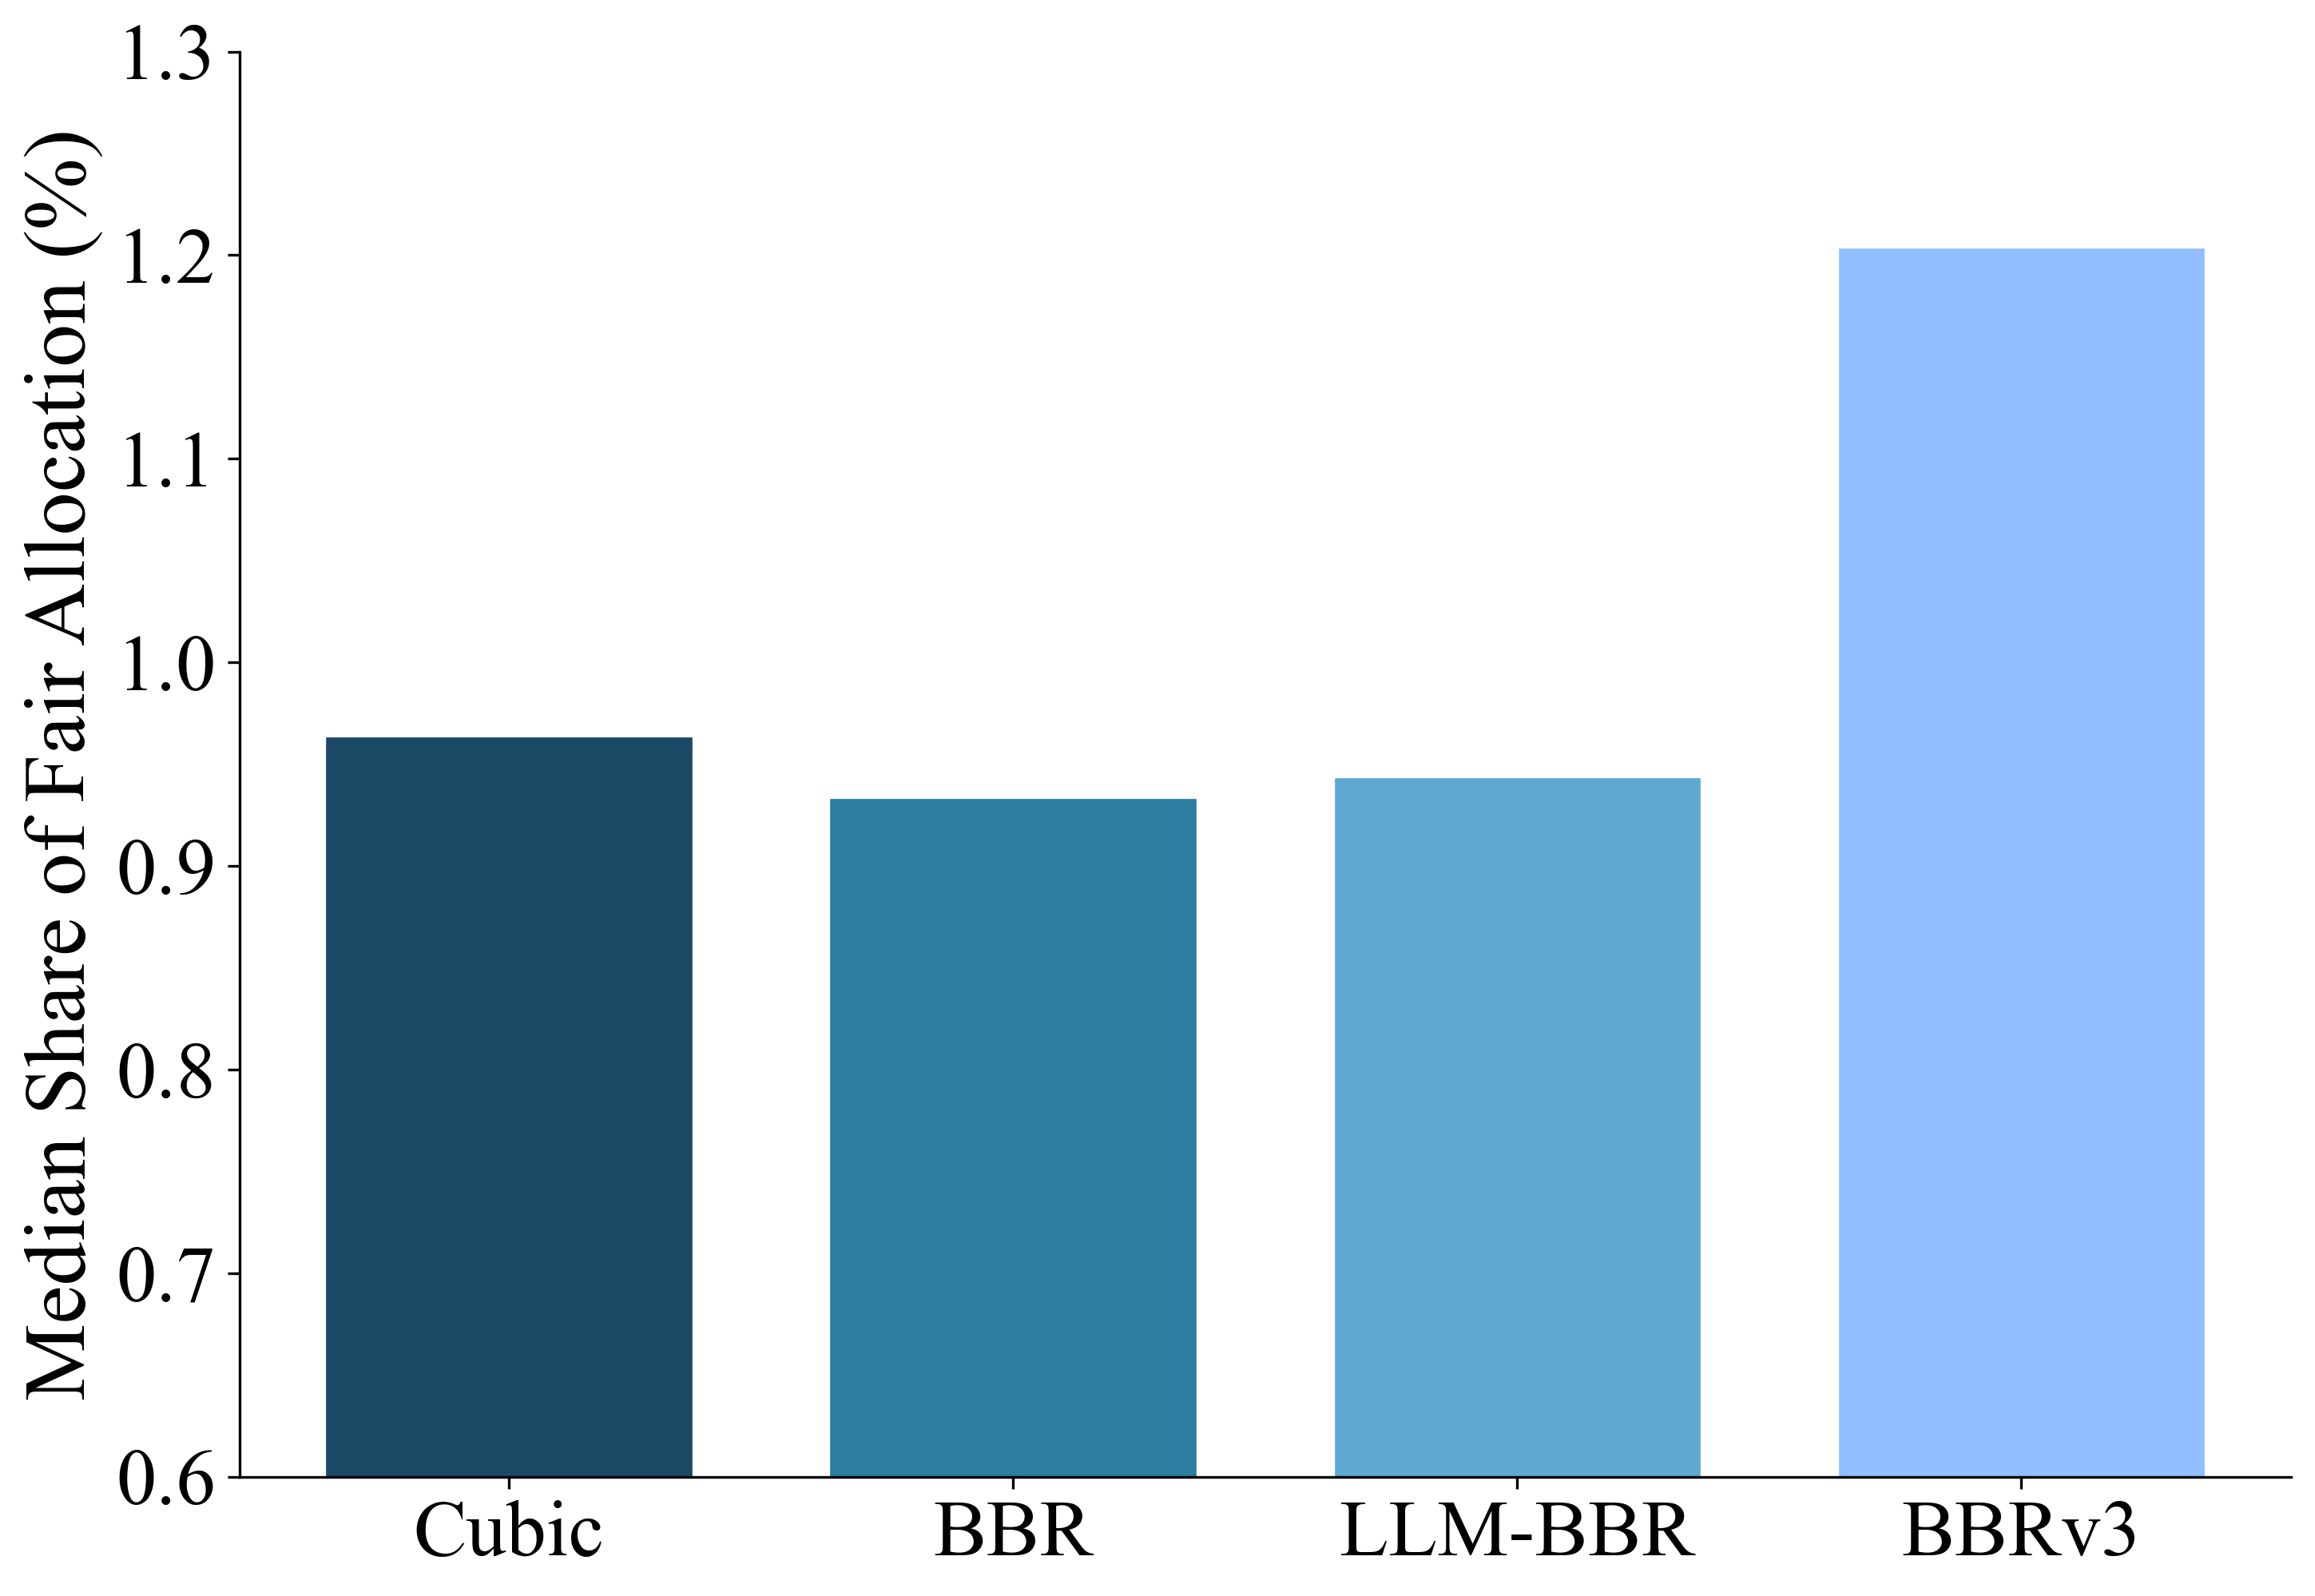

In [54]:
def plot_share_of_bandwidth_summary():
    """
    Generates a bar chart for share of bandwidth.
    
    This function synthesizes data from the provided Mean and SEM
    to generate a distribution, as box plots cannot be drawn from
    summary statistics alone. We assume a normal distribution and
    treat the SEM as the standard deviation for the generator.
    """
    print("Generating Share of Bandwidth plot from summary stats...")
    
    # Your provided summary data
    summary_data = {
        'cubic': {'mean': 0.96, 'sem': 0.0},
        'bbr': {'mean': 0.93, 'sem': 0.0},
        'llm_bbr': {'mean': 0.94, 'sem': 0.0},
        'bbr_v3': {'mean': 1.20, 'sem': 0.0},
    }
    
    # Map for algorithm keys to display names
    label_map = {
        'cubic': 'Cubic',
        'bbr': 'BBR',
        'llm_bbr': 'LLM-BBR',
        'bbr_v3': 'BBRv3',
    }
    plot_bar_chart(summary_data, label_map, "Median Share of Fair Allocation (%)", ylim=[0.6, 1.3], output='share_of_bandwidth.png')

plot_share_of_bandwidth_summary()